yrury

In [10]:
# Cell 1: Imports and Setup
import os
# Disable tokenizers parallelism to avoid fork warnings with DataLoader
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import sys
sys.path.append('CIPS-Net')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import albumentations as A
from datetime import datetime
import yaml
import json
from sklearn.metrics import f1_score, precision_score, recall_score

# Reload CIPS-Net modules
modules_to_reload = [
    'CIPS-Net.models.image_encoder',
    'CIPS-Net.models.text_encoder',
    'CIPS-Net.models.instruction_grounding',
    'CIPS-Net.models.decoder',
    'CIPS-Net.models.cips_net',
    'CIPS-Net.models'
]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

from models.cips_net import CIPSNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("\n" + "=" * 60)
print("CIPS-Net PanNuke Training with 3-Fold Cross-Validation")
print("=" * 60)

Using device: cuda
GPU: NVIDIA RTX A5000
Memory: 25.28 GB

CIPS-Net PanNuke Training with 3-Fold Cross-Validation


## 1. Configuration

In [11]:
# Cell 2: Configuration

# ============================================================================
# EXPERIMENT CONFIGURATION
# ============================================================================

# =============================================
# LOSS FUNCTION SELECTION - CHANGE THIS TO COMPARE
# =============================================
# Options: 'balanced' (Focal + Weighted Dice) or 'standard' (CE + Dice)
LOSS_TYPE = 'balanced'  # <-- CHANGE THIS TO 'balanced' or 'standard'
# =============================================

CONFIG = {
    # Experiment - name changes based on loss type
    'experiment_name': f'cipsnet_pannuke_cv3_{LOSS_TYPE}_VIT_L_16_Bio_ClinicalBERT_',
    'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S'),
    'loss_type': LOSS_TYPE,
    
    # Dataset
    'dataset_path': 'PanNuke_Preprocess',
    'num_folds': 3,
    'img_size': 224,
    
    # Classes (ordered by index)
    'class_names': ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Dead', 'Epithelial'],
    'num_classes': 5,
    
    # Class frequencies from PanNuke (approximate % of images containing each class)
    # Used for computing class weights - inverse frequency weighting
    'class_frequencies': [0.53, 0.523, 0.777, 0.029, 0.193],  # Neoplastic, Inflammatory, Connective, Dead, Epithelial
    
    # Training
    'num_epochs': 50,
    'batch_size': 16,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'num_workers': 0,  # Set to 0 to avoid multiprocessing warnings
    
    # Loss settings (only used if loss_type == 'balanced')
    'focal_gamma': 2.0,  # Focal loss gamma parameter
    'focal_alpha': None,  # Will be computed from class frequencies
    'dice_weight': 1.0,
    'focal_weight': 1.0,
    
    # Model
    'img_encoder': 'vit_l_16',
    'text_encoder': 'emilyalsentzer/Bio_ClinicalBERT',
    'embed_dim': 768,
    
    # Normalization
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
}

# Compute class weights from inverse frequency (for class imbalance)
# Only used if loss_type == 'balanced'
class_freqs = np.array(CONFIG['class_frequencies'])
inverse_freqs = 1.0 / (class_freqs + 1e-6)
class_weights = inverse_freqs / inverse_freqs.sum() * len(class_freqs)
CONFIG['class_weights'] = class_weights.tolist()

print("=" * 60)
print(f"LOSS FUNCTION: {LOSS_TYPE.upper()}")
print("=" * 60)

if LOSS_TYPE == 'balanced':
    print("Using: BalancedCombinedLoss (Focal + Class-Weighted Dice)")
    print("\nClass Weights for Imbalance Handling:")
    for name, weight in zip(CONFIG['class_names'], CONFIG['class_weights']):
        print(f"  {name}: {weight:.4f}")
else:
    print("Using: StandardCombinedLoss (CrossEntropy + Dice)")
    print("  No class weighting applied")

# Create results directory with descriptive naming
RESULTS_DIR = f"results/{CONFIG['experiment_name']}_{CONFIG['timestamp']}"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(f"{RESULTS_DIR}/models", exist_ok=True)
os.makedirs(f"{RESULTS_DIR}/logs", exist_ok=True)
os.makedirs(f"{RESULTS_DIR}/visualizations", exist_ok=True)

# Save config
with open(f"{RESULTS_DIR}/config.yaml", 'w') as f:
    yaml.dump(CONFIG, f, default_flow_style=False)

print(f"\nExperiment: {CONFIG['experiment_name']}")
print(f"Results directory: {RESULTS_DIR}")
print(f"\nConfiguration:")
for key, value in CONFIG.items():
    if key != 'class_weights':
        print(f"  {key}: {value}")

LOSS FUNCTION: BALANCED
Using: BalancedCombinedLoss (Focal + Class-Weighted Dice)

Class Weights for Imbalance Handling:
  Neoplastic: 0.2108
  Inflammatory: 0.2136
  Connective_Soft_tissue: 0.1438
  Dead: 3.8528
  Epithelial: 0.5789

Experiment: cipsnet_pannuke_cv3_balanced_VIT_L_16_Bio_ClinicalBERT_
Results directory: results/cipsnet_pannuke_cv3_balanced_VIT_L_16_Bio_ClinicalBERT__20260127_144306

Configuration:
  experiment_name: cipsnet_pannuke_cv3_balanced_VIT_L_16_Bio_ClinicalBERT_
  timestamp: 20260127_144306
  loss_type: balanced
  dataset_path: PanNuke_Preprocess
  num_folds: 3
  img_size: 224
  class_names: ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Dead', 'Epithelial']
  num_classes: 5
  class_frequencies: [0.53, 0.523, 0.777, 0.029, 0.193]
  num_epochs: 50
  batch_size: 16
  learning_rate: 0.0001
  weight_decay: 1e-05
  num_workers: 0
  focal_gamma: 2.0
  focal_alpha: None
  dice_weight: 1.0
  focal_weight: 1.0
  img_encoder: vit_l_16
  text_encoder: emilyals

## 2. Dataset Class for PanNuke

In [12]:
# Cell 3: PanNuke Dataset Class

class PanNukeDataset(Dataset):
    """
    Dataset for PanNuke with preprocessed format.
    
    - Images: PNG files in images/fold{n}/
    - Masks: NPZ files in masks/fold{n}/ containing binary masks per class
    - Annotations: annotations.csv with image_id, fold, classes_present, instruction
    """
    
    def __init__(
        self,
        data_root: str,
        folds: list,
        transform=None,
        img_size: int = 224,
        class_names: list = None
    ):
        self.data_root = data_root
        self.folds = folds
        self.transform = transform
        self.img_size = img_size
        self.class_names = class_names or CONFIG['class_names']
        self.num_classes = len(self.class_names)
        
        # Load annotations
        annotations = pd.read_csv(os.path.join(data_root, 'annotations.csv'))
        self.df = annotations[annotations['fold'].isin(folds)].reset_index(drop=True)
        
        print(f"Loaded {len(self.df)} samples from folds {folds}")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['image_id']
        fold = row['fold']
        
        # Load image
        img_path = os.path.join(self.data_root, 'images', f'fold{fold}', f'{image_id}.png')
        image = np.array(Image.open(img_path).convert('RGB'))
        
        # Load masks
        mask_path = os.path.join(self.data_root, 'masks', f'fold{fold}', f'{image_id}.npz')
        mask_data = np.load(mask_path)
        masks = mask_data['masks']  # [H, W, num_classes] binary masks
        
        # Create class index mask from binary masks
        # Priority: later classes override earlier ones if overlapping
        class_index_mask = np.zeros((masks.shape[0], masks.shape[1]), dtype=np.int64)
        for c in range(self.num_classes):
            class_index_mask[masks[:, :, c] > 0] = c
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=class_index_mask)
            image = augmented['image']
            class_index_mask = augmented['mask']
        
        # Convert to tensors
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float()
        elif isinstance(image, torch.Tensor) and image.ndim == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1).float()
        
        if isinstance(class_index_mask, np.ndarray):
            class_index_mask = torch.from_numpy(class_index_mask.astype(np.int64)).long()
        else:
            class_index_mask = class_index_mask.long()
        
        # Get instruction
        instruction = row['instruction'] if pd.notna(row['instruction']) else "Segment all tissue types."
        
        return {
            'image': image,
            'mask': class_index_mask,
            'instruction': instruction,
            'image_id': image_id,
            'classes_present': row['classes_present'],
            'tissue_type': row['tissue_type']
        }


def get_transforms(img_size, mean, std, augment=True):
    """Get augmentation transforms."""
    if augment:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
            A.GaussianBlur(blur_limit=(3, 5), p=0.2),
            A.Normalize(mean=mean, std=std),
        ])
    else:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(mean=mean, std=std),
        ])


def collate_fn(batch):
    """Custom collate function."""
    images = torch.stack([item['image'] for item in batch])
    masks = torch.stack([item['mask'] for item in batch])
    instructions = [item['instruction'] for item in batch]
    image_ids = [item['image_id'] for item in batch]
    return {
        'image': images,
        'mask': masks,
        'instruction': instructions,
        'image_id': image_ids
    }


print("✓ PanNukeDataset class defined!")

✓ PanNukeDataset class defined!


## 3. Loss Functions and Metrics

In [13]:
# Cell 4: Loss Functions and Segmentation Metrics

# ============================================================================
# FOCAL LOSS - Better for class imbalance
# ============================================================================

class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance.
    FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)
    
    - gamma > 0 reduces the relative loss for well-classified examples
    - alpha provides class balancing
    """
    
    def __init__(self, num_classes, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.num_classes = num_classes
        self.gamma = gamma
        self.reduction = reduction
        
        if alpha is None:
            self.alpha = torch.ones(num_classes)
        else:
            self.alpha = torch.tensor(alpha, dtype=torch.float32)
    
    def forward(self, logits, targets):
        # logits: [B, C, H, W], targets: [B, H, W]
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        
        # Get probabilities
        probs = F.softmax(logits, dim=1)
        
        # Get the probability of the true class
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()  # [B, C, H, W]
        
        pt = (probs * targets_one_hot).sum(dim=1)  # [B, H, W]
        
        # Focal weight
        focal_weight = (1 - pt) ** self.gamma
        
        # Alpha weight per class
        alpha = self.alpha.to(logits.device)
        alpha_t = (alpha.view(1, -1, 1, 1) * targets_one_hot).sum(dim=1)  # [B, H, W]
        
        # Focal loss
        focal_loss = alpha_t * focal_weight * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss


# ============================================================================
# CLASS-WEIGHTED DICE LOSS
# ============================================================================

class ClassWeightedDiceLoss(nn.Module):
    """
    Class-weighted Dice Loss for handling class imbalance.
    Applies higher weights to minority classes.
    """
    
    def __init__(self, num_classes, class_weights=None, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth
        
        if class_weights is None:
            self.class_weights = torch.ones(num_classes)
        else:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32)
    
    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)
        
        # One-hot encode targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()
        
        weights = self.class_weights.to(logits.device)
        
        # Compute weighted Dice per class
        dice_per_class = []
        for c in range(self.num_classes):
            pred_c = probs[:, c, :, :]
            target_c = targets_one_hot[:, c, :, :]
            
            intersection = (pred_c * target_c).sum()
            union = pred_c.sum() + target_c.sum()
            
            dice_c = (2.0 * intersection + self.smooth) / (union + self.smooth)
            # Weight by class importance
            weighted_dice = weights[c] * dice_c
            dice_per_class.append(weighted_dice)
        
        # Weighted mean
        total_weight = weights.sum()
        weighted_mean_dice = torch.stack(dice_per_class).sum() / total_weight
        
        return 1.0 - weighted_mean_dice


# ============================================================================
# COMBINED LOSS FUNCTIONS
# ============================================================================

class BalancedCombinedLoss(nn.Module):
    """
    Combined Focal Loss + Class-Weighted Dice Loss for severe class imbalance.
    
    This combination is effective because:
    - Focal Loss: Down-weights easy examples, focuses on hard ones
    - Weighted Dice: Handles spatial imbalance and gives more importance to minority classes
    """
    
    def __init__(self, num_classes, class_weights=None, focal_gamma=2.0, 
                 focal_weight=1.0, dice_weight=1.0):
        super().__init__()
        self.focal_loss = FocalLoss(
            num_classes=num_classes, 
            gamma=focal_gamma, 
            alpha=class_weights
        )
        self.dice_loss = ClassWeightedDiceLoss(
            num_classes=num_classes,
            class_weights=class_weights
        )
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
    
    def forward(self, logits, targets):
        focal = self.focal_loss(logits, targets)
        dice = self.dice_loss(logits, targets)
        return self.focal_weight * focal + self.dice_weight * dice


class StandardCombinedLoss(nn.Module):
    """
    Standard Combined Loss: CrossEntropy + Dice Loss (no class balancing).
    """
    
    def __init__(self, num_classes, ce_weight=1.0, dice_weight=1.0):
        super().__init__()
        self.num_classes = num_classes
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
    
    def forward(self, logits, targets):
        # Cross-entropy
        ce_loss = F.cross_entropy(logits, targets)
        
        # Dice loss (unweighted)
        probs = F.softmax(logits, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()
        
        dice_per_class = []
        for c in range(self.num_classes):
            pred_c = probs[:, c, :, :]
            target_c = targets_one_hot[:, c, :, :]
            
            intersection = (pred_c * target_c).sum()
            union = pred_c.sum() + target_c.sum()
            
            dice_c = (2.0 * intersection + 1e-6) / (union + 1e-6)
            dice_per_class.append(dice_c)
        
        dice_loss = 1.0 - torch.stack(dice_per_class).mean()
        
        return self.ce_weight * ce_loss + self.dice_weight * dice_loss


def get_loss_function(config):
    """Factory function to get the appropriate loss function."""
    loss_type = config.get('loss_type', 'balanced')
    
    if loss_type == 'balanced':
        return BalancedCombinedLoss(
            num_classes=config['num_classes'],
            class_weights=config['class_weights'],
            focal_gamma=config['focal_gamma'],
            focal_weight=config['focal_weight'],
            dice_weight=config['dice_weight']
        )
    else:  # 'standard'
        return StandardCombinedLoss(
            num_classes=config['num_classes'],
            ce_weight=1.0,
            dice_weight=1.0
        )


# ============================================================================
# SEGMENTATION METRICS (Dice, IoU, F1 - No PQ for training)
# ============================================================================

class SegmentationMetrics:
    """
    Segmentation metrics for training tracking:
    - Dice Score (per-class and macro)
    - IoU / Jaccard (per-class and macro)
    - F1-Score (per-class and macro)
    - Precision and Recall (per-class and macro)
    
    Note: Panoptic Quality (bPQ, mPQ) is computed separately in the evaluation
    notebook using proper instance-based matching (connected components).
    """
    
    def __init__(self, num_classes, class_names):
        self.num_classes = num_classes
        self.class_names = class_names
        self.reset()
    
    def reset(self):
        """Reset all accumulators."""
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes), dtype=np.int64)
        self.total_pixels = 0
    
    def update(self, preds, targets):
        """
        Update metrics with batch predictions.
        
        Args:
            preds: [B, H, W] predicted class indices
            targets: [B, H, W] ground truth class indices
        """
        preds_flat = preds.cpu().numpy().flatten()
        targets_flat = targets.cpu().numpy().flatten()
        
        # Update confusion matrix
        for c_pred in range(self.num_classes):
            for c_true in range(self.num_classes):
                self.confusion_matrix[c_true, c_pred] += np.sum(
                    (preds_flat == c_pred) & (targets_flat == c_true)
                )
        
        self.total_pixels += len(preds_flat)
    
    def compute(self):
        """
        Compute all metrics from confusion matrix.
        
        Returns:
            Dictionary with per-class and macro metrics
        """
        metrics = {}
        
        # Per-class metrics
        dice_per_class = []
        iou_per_class = []
        f1_per_class = []
        precision_per_class = []
        recall_per_class = []
        
        for c in range(self.num_classes):
            tp = self.confusion_matrix[c, c]
            fp = self.confusion_matrix[:, c].sum() - tp
            fn = self.confusion_matrix[c, :].sum() - tp
            
            # Dice = 2*TP / (2*TP + FP + FN)
            dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)
            dice_per_class.append(dice)
            
            # IoU = TP / (TP + FP + FN)
            iou = tp / (tp + fp + fn + 1e-8)
            iou_per_class.append(iou)
            
            # Precision = TP / (TP + FP)
            precision = tp / (tp + fp + 1e-8)
            precision_per_class.append(precision)
            
            # Recall = TP / (TP + FN)
            recall = tp / (tp + fn + 1e-8)
            recall_per_class.append(recall)
            
            # F1 = 2 * Precision * Recall / (Precision + Recall)
            f1 = (2 * precision * recall) / (precision + recall + 1e-8)
            f1_per_class.append(f1)
            
            # Store per-class metrics
            class_name = self.class_names[c]
            metrics[f'dice_{class_name}'] = dice
            metrics[f'iou_{class_name}'] = iou
            metrics[f'f1_{class_name}'] = f1
            metrics[f'precision_{class_name}'] = precision
            metrics[f'recall_{class_name}'] = recall
        
        # Macro-averaged metrics
        metrics['dice_macro'] = np.mean(dice_per_class)
        metrics['iou_macro'] = np.mean(iou_per_class)
        metrics['f1_macro'] = np.mean(f1_per_class)
        metrics['precision_macro'] = np.mean(precision_per_class)
        metrics['recall_macro'] = np.mean(recall_per_class)
        
        # Overall accuracy
        correct = np.diag(self.confusion_matrix).sum()
        metrics['accuracy'] = correct / (self.total_pixels + 1e-8)
        
        return metrics


print("✓ Loss functions defined:")
print("  - FocalLoss: For hard example mining with class imbalance")
print("  - ClassWeightedDiceLoss: Weighted by inverse class frequency")
print("  - BalancedCombinedLoss: Focal + Weighted Dice")
print("  - StandardCombinedLoss: CrossEntropy + Dice (no balancing)")
print("  - get_loss_function(): Factory to select based on CONFIG['loss_type']")
print("\n✓ Metrics defined:")
print("  - Dice, IoU, F1, Precision, Recall (per-class and macro)")
print("\n📝 Note: Panoptic Quality (bPQ, mPQ) will be computed in a separate")
print("   evaluation notebook using proper instance-based matching.")

✓ Loss functions defined:
  - FocalLoss: For hard example mining with class imbalance
  - ClassWeightedDiceLoss: Weighted by inverse class frequency
  - BalancedCombinedLoss: Focal + Weighted Dice
  - StandardCombinedLoss: CrossEntropy + Dice (no balancing)
  - get_loss_function(): Factory to select based on CONFIG['loss_type']

✓ Metrics defined:
  - Dice, IoU, F1, Precision, Recall (per-class and macro)

📝 Note: Panoptic Quality (bPQ, mPQ) will be computed in a separate
   evaluation notebook using proper instance-based matching.


## 4. Training and Validation Functions

In [14]:
# Cell 5: Training and Validation Functions

def train_epoch(model, loader, criterion, optimizer, device, metrics_tracker):
    """
    Train for one epoch.
    
    Returns:
        avg_loss, metrics_dict
    """
    model.train()
    metrics_tracker.reset()
    running_loss = 0.0
    num_batches = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        instructions = batch['instruction']
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images, instructions)
        logits = outputs['masks'][:, :CONFIG['num_classes'], :, :]  # Take only class channels
        
        # Loss
        loss = criterion(logits, masks)
        
        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Update metrics
        with torch.no_grad():
            preds = torch.argmax(logits, dim=1)
            metrics_tracker.update(preds, masks)
        
        running_loss += loss.item()
        num_batches += 1
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = running_loss / num_batches
    metrics = metrics_tracker.compute()
    
    return avg_loss, metrics


def validate_epoch(model, loader, criterion, device, metrics_tracker):
    """
    Validate for one epoch.
    
    Returns:
        avg_loss, metrics_dict
    """
    model.eval()
    metrics_tracker.reset()
    running_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for batch in pbar:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            instructions = batch['instruction']
            
            # Forward pass
            outputs = model(images, instructions)
            logits = outputs['masks'][:, :CONFIG['num_classes'], :, :]
            
            # Loss
            loss = criterion(logits, masks)
            
            # Update metrics
            preds = torch.argmax(logits, dim=1)
            metrics_tracker.update(preds, masks)
            
            running_loss += loss.item()
            num_batches += 1
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = running_loss / num_batches
    metrics = metrics_tracker.compute()
    
    return avg_loss, metrics


def test_epoch(model, loader, device, metrics_tracker):
    """
    Test/evaluate without computing loss.
    
    Returns:
        metrics_dict
    """
    model.eval()
    metrics_tracker.reset()
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Testing', leave=False)
        for batch in pbar:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            instructions = batch['instruction']
            
            # Forward pass
            outputs = model(images, instructions)
            logits = outputs['masks'][:, :CONFIG['num_classes'], :, :]
            
            # Update metrics
            preds = torch.argmax(logits, dim=1)
            metrics_tracker.update(preds, masks)
    
    metrics = metrics_tracker.compute()
    return metrics


print("✓ Training, validation, and testing functions defined!")
print("  All phases compute: Dice, IoU, F1, Precision, Recall")

✓ Training, validation, and testing functions defined!
  All phases compute: Dice, IoU, F1, Precision, Recall


## 5. Cross-Validation Training Loop

In [15]:
# Cell 6: Cross-Validation Training Function

def train_fold(fold_idx, train_folds, val_fold, config, results_dir):
    """
    Train a single fold with comprehensive metrics.
    
    Args:
        fold_idx: Fold number (1, 2, or 3)
        train_folds: List of folds for training
        val_fold: Fold for validation
        config: Configuration dictionary
        results_dir: Directory to save results
    
    Returns:
        best_metrics, history
    """
    print("\n" + "=" * 80)
    print(f"FOLD {fold_idx}: Train on folds {train_folds}, Validate on fold {val_fold}")
    print(f"Loss Type: {config.get('loss_type', 'balanced')}")
    print("=" * 80)
    
    # Create fold-specific directories
    fold_dir = f"{results_dir}/fold{fold_idx}"
    os.makedirs(fold_dir, exist_ok=True)
    
    # Transforms
    train_transform = get_transforms(config['img_size'], config['mean'], config['std'], augment=True)
    val_transform = get_transforms(config['img_size'], config['mean'], config['std'], augment=False)
    
    # Datasets
    train_dataset = PanNukeDataset(
        data_root=config['dataset_path'],
        folds=train_folds,
        transform=train_transform,
        img_size=config['img_size']
    )
    
    val_dataset = PanNukeDataset(
        data_root=config['dataset_path'],
        folds=[val_fold],
        transform=val_transform,
        img_size=config['img_size']
    )
    
    # DataLoaders (num_workers=0 to avoid warnings)
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],  # Set to 0 in config
        collate_fn=collate_fn,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],  # Set to 0 in config
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
    
    if config.get('loss_type', 'balanced') == 'balanced':
        print(f"Using class-balanced loss with weights: {[f'{w:.2f}' for w in config['class_weights']]}")
    else:
        print("Using standard loss (CE + Dice, no class balancing)")
    
    # Initialize model
    model = CIPSNet(
        img_encoder_name=config['img_encoder'],
        text_encoder_name=config['text_encoder'],
        embed_dim=config['embed_dim'],
        num_classes=config['num_classes'],
        img_size=config['img_size'],
        pretrained=True
    ).to(device)
    
    # Get loss function based on config
    criterion = get_loss_function(config)
    
    optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    scheduler = CosineAnnealingLR(optimizer, T_max=config['num_epochs'], eta_min=1e-6)
    
    # Metrics tracker
    train_metrics = SegmentationMetrics(config['num_classes'], config['class_names'])
    val_metrics = SegmentationMetrics(config['num_classes'], config['class_names'])
    
    # Training history
    history = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'train_dice_macro': [],
        'val_dice_macro': [],
        'val_iou_macro': [],
        'val_f1_macro': [],
        'learning_rate': []
    }
    
    # Per-class metrics in history
    for name in config['class_names']:
        history[f'val_dice_{name}'] = []
        history[f'val_iou_{name}'] = []
        history[f'val_f1_{name}'] = []
    
    best_dice = 0.0
    best_epoch = 0
    best_metrics = None
    
    # Training loop
    for epoch in range(config['num_epochs']):
        # Train
        train_loss, train_m = train_epoch(model, train_loader, criterion, optimizer, device, train_metrics)
        
        # Validate
        val_loss, val_m = validate_epoch(model, val_loader, criterion, device, val_metrics)
        
        # Update scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_dice_macro'].append(train_m['dice_macro'])
        history['val_dice_macro'].append(val_m['dice_macro'])
        history['val_iou_macro'].append(val_m['iou_macro'])
        history['val_f1_macro'].append(val_m['f1_macro'])
        history['learning_rate'].append(current_lr)
        
        for name in config['class_names']:
            history[f'val_dice_{name}'].append(val_m[f'dice_{name}'])
            history[f'val_iou_{name}'].append(val_m[f'iou_{name}'])
            history[f'val_f1_{name}'].append(val_m[f'f1_{name}'])
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{config['num_epochs']} | LR: {current_lr:.2e}")
        print(f"  Train Loss: {train_loss:.4f} | Train Dice: {train_m['dice_macro']:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val Dice:   {val_m['dice_macro']:.4f}")
        print(f"  Val IoU: {val_m['iou_macro']:.4f} | Val F1: {val_m['f1_macro']:.4f}")
        
        # Per-class Dice
        print("  Per-class Dice:")
        for name in config['class_names']:
            print(f"    {name}: {val_m[f'dice_{name}']:.4f}")
        
        # Save best model
        if val_m['dice_macro'] > best_dice:
            best_dice = val_m['dice_macro']
            best_epoch = epoch + 1
            best_metrics = val_m.copy()
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_dice': best_dice,
                'metrics': best_metrics,
                'config': config
            }
            torch.save(checkpoint, f"{fold_dir}/best_model.pth")
            print(f"  *** New Best Model! Dice: {best_dice:.4f} ***")
    
    # Save final model
    torch.save({
        'epoch': config['num_epochs'],
        'model_state_dict': model.state_dict(),
        'metrics': val_m,
        'config': config
    }, f"{fold_dir}/last_model.pth")
    
    # Save history
    history_df = pd.DataFrame(history)
    history_df.to_csv(f"{fold_dir}/training_history.csv", index=False)
    
    # Save best metrics
    best_metrics['best_epoch'] = best_epoch
    best_metrics['fold'] = fold_idx
    with open(f"{fold_dir}/best_metrics.json", 'w') as f:
        json.dump({k: float(v) if isinstance(v, (np.floating, float)) else v 
                   for k, v in best_metrics.items()}, f, indent=2)
    
    print(f"\nFold {fold_idx} Complete!")
    print(f"  Best Epoch: {best_epoch}")
    print(f"  Best Val Dice: {best_dice:.4f}")
    
    # Cleanup
    del model
    torch.cuda.empty_cache()
    
    return best_metrics, history


print("✓ Cross-validation training function defined!")
print("  - Uses get_loss_function() to select loss based on CONFIG['loss_type']")
print("  - Tracks standard metrics: Dice, IoU, F1, Precision, Recall")
print("\n📝 Note: Panoptic Quality (bPQ, mPQ) will be computed in evaluate_cipsnet_pannuke.ipynb")

✓ Cross-validation training function defined!
  - Uses get_loss_function() to select loss based on CONFIG['loss_type']
  - Tracks standard metrics: Dice, IoU, F1, Precision, Recall

📝 Note: Panoptic Quality (bPQ, mPQ) will be computed in evaluate_cipsnet_pannuke.ipynb


## 6. Run 3-Fold Cross-Validation

In [ ]:
# Cell 7: Run 3-Fold Cross-Validation

print("=" * 80)
print("STARTING 3-FOLD CROSS-VALIDATION")
print("=" * 80)

# Cross-validation splits
cv_splits = [
    {'fold_idx': 1, 'train_folds': [2, 3], 'val_fold': 1},
    {'fold_idx': 2, 'train_folds': [1, 3], 'val_fold': 2},
    {'fold_idx': 3, 'train_folds': [1, 2], 'val_fold': 3},
]

# Store results for all folds
all_fold_results = []
all_fold_histories = []

for split in cv_splits:
    fold_metrics, fold_history = train_fold(
        fold_idx=split['fold_idx'],
        train_folds=split['train_folds'],
        val_fold=split['val_fold'],
        config=CONFIG,
        results_dir=RESULTS_DIR
    )
    all_fold_results.append(fold_metrics)
    all_fold_histories.append(fold_history)

print("\n" + "=" * 80)
print("CROSS-VALIDATION COMPLETE!")
print("=" * 80)

STARTING 3-FOLD CROSS-VALIDATION

FOLD 1: Train on folds [2, 3], Validate on fold 1
Loss Type: balanced
Loaded 5245 samples from folds [2, 3]
Loaded 2656 samples from folds [1]
Train samples: 5245, Val samples: 2656
Using class-balanced loss with weights: ['0.21', '0.21', '0.14', '3.85', '0.58']


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 1/50 | LR: 9.99e-05
  Train Loss: 1.1089 | Train Dice: 0.1985
  Val Loss:   1.0443 | Val Dice:   0.2247
  Val IoU: 0.1912 | Val F1: 0.2247
  Per-class Dice:
    Neoplastic: 0.9113
    Inflammatory: 0.0000
    Connective_Soft_tissue: 0.0000
    Dead: 0.0000
    Epithelial: 0.2124
  *** New Best Model! Dice: 0.2247 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 2/50 | LR: 9.96e-05
  Train Loss: 1.0216 | Train Dice: 0.2242
  Val Loss:   1.0233 | Val Dice:   0.2255
  Val IoU: 0.1942 | Val F1: 0.2255
  Per-class Dice:
    Neoplastic: 0.9230
    Inflammatory: 0.0000
    Connective_Soft_tissue: 0.0000
    Dead: 0.0000
    Epithelial: 0.2043
  *** New Best Model! Dice: 0.2255 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 3/50 | LR: 9.91e-05
  Train Loss: 1.0052 | Train Dice: 0.2233
  Val Loss:   1.0152 | Val Dice:   0.1917
  Val IoU: 0.1840 | Val F1: 0.1917
  Per-class Dice:
    Neoplastic: 0.9583
    Inflammatory: 0.0000
    Connective_Soft_tissue: 0.0000
    Dead: 0.0000
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 4/50 | LR: 9.84e-05
  Train Loss: 0.9909 | Train Dice: 0.2284
  Val Loss:   1.0075 | Val Dice:   0.2337
  Val IoU: 0.2010 | Val F1: 0.2337
  Per-class Dice:
    Neoplastic: 0.9387
    Inflammatory: 0.0000
    Connective_Soft_tissue: 0.0735
    Dead: 0.0418
    Epithelial: 0.1148
  *** New Best Model! Dice: 0.2337 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 5/50 | LR: 9.76e-05
  Train Loss: 0.9816 | Train Dice: 0.2277
  Val Loss:   1.0039 | Val Dice:   0.2135
  Val IoU: 0.1904 | Val F1: 0.2135
  Per-class Dice:
    Neoplastic: 0.9393
    Inflammatory: 0.0002
    Connective_Soft_tissue: 0.0859
    Dead: 0.0420
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 6/50 | LR: 9.65e-05
  Train Loss: 0.9772 | Train Dice: 0.2245
  Val Loss:   1.0027 | Val Dice:   0.2452
  Val IoU: 0.2027 | Val F1: 0.2452
  Per-class Dice:
    Neoplastic: 0.9185
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0485
    Dead: 0.0419
    Epithelial: 0.1838
  *** New Best Model! Dice: 0.2452 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 7/50 | LR: 9.53e-05
  Train Loss: 0.9730 | Train Dice: 0.2268
  Val Loss:   1.0009 | Val Dice:   0.2124
  Val IoU: 0.1896 | Val F1: 0.2124
  Per-class Dice:
    Neoplastic: 0.9392
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0484
    Dead: 0.0413
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 8/50 | LR: 9.39e-05
  Train Loss: 0.9706 | Train Dice: 0.2245
  Val Loss:   0.9994 | Val Dice:   0.2126
  Val IoU: 0.1897 | Val F1: 0.2126
  Per-class Dice:
    Neoplastic: 0.9392
    Inflammatory: 0.0332
    Connective_Soft_tissue: 0.0486
    Dead: 0.0418
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 9/50 | LR: 9.23e-05
  Train Loss: 0.9673 | Train Dice: 0.2244
  Val Loss:   0.9989 | Val Dice:   0.2146
  Val IoU: 0.1905 | Val F1: 0.2146
  Per-class Dice:
    Neoplastic: 0.9385
    Inflammatory: 0.0332
    Connective_Soft_tissue: 0.0488
    Dead: 0.0368
    Epithelial: 0.0155


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 10/50 | LR: 9.05e-05
  Train Loss: 0.9675 | Train Dice: 0.2239
  Val Loss:   1.0002 | Val Dice:   0.2120
  Val IoU: 0.1875 | Val F1: 0.2120
  Per-class Dice:
    Neoplastic: 0.9320
    Inflammatory: 0.0332
    Connective_Soft_tissue: 0.0402
    Dead: 0.0378
    Epithelial: 0.0168


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 11/50 | LR: 8.86e-05
  Train Loss: 0.9648 | Train Dice: 0.2228
  Val Loss:   0.9982 | Val Dice:   0.2126
  Val IoU: 0.1897 | Val F1: 0.2126
  Per-class Dice:
    Neoplastic: 0.9391
    Inflammatory: 0.0332
    Connective_Soft_tissue: 0.0489
    Dead: 0.0418
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 12/50 | LR: 8.66e-05
  Train Loss: 0.9654 | Train Dice: 0.2188
  Val Loss:   0.9988 | Val Dice:   0.2138
  Val IoU: 0.1904 | Val F1: 0.2138
  Per-class Dice:
    Neoplastic: 0.9394
    Inflammatory: 0.0332
    Connective_Soft_tissue: 0.0489
    Dead: 0.0475
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 13/50 | LR: 8.44e-05
  Train Loss: 0.9636 | Train Dice: 0.2165
  Val Loss:   1.0002 | Val Dice:   0.2144
  Val IoU: 0.1908 | Val F1: 0.2144
  Per-class Dice:
    Neoplastic: 0.9395
    Inflammatory: 0.0332
    Connective_Soft_tissue: 0.0489
    Dead: 0.0504
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 14/50 | LR: 8.21e-05
  Train Loss: 0.9624 | Train Dice: 0.2154
  Val Loss:   0.9996 | Val Dice:   0.2146
  Val IoU: 0.1910 | Val F1: 0.2146
  Per-class Dice:
    Neoplastic: 0.9391
    Inflammatory: 0.0035
    Connective_Soft_tissue: 0.0887
    Dead: 0.0419
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 15/50 | LR: 7.96e-05
  Train Loss: 0.9627 | Train Dice: 0.2180
  Val Loss:   1.0003 | Val Dice:   0.2245
  Val IoU: 0.1958 | Val F1: 0.2245
  Per-class Dice:
    Neoplastic: 0.9381
    Inflammatory: 0.0033
    Connective_Soft_tissue: 0.0888
    Dead: 0.0491
    Epithelial: 0.0433


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 16/50 | LR: 7.70e-05
  Train Loss: 0.9609 | Train Dice: 0.2218
  Val Loss:   0.9991 | Val Dice:   0.2337
  Val IoU: 0.1996 | Val F1: 0.2337
  Per-class Dice:
    Neoplastic: 0.9342
    Inflammatory: 0.0332
    Connective_Soft_tissue: 0.0489
    Dead: 0.0419
    Epithelial: 0.1102


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 17/50 | LR: 7.43e-05
  Train Loss: 0.9616 | Train Dice: 0.2177
  Val Loss:   1.0002 | Val Dice:   0.2172
  Val IoU: 0.1918 | Val F1: 0.2172
  Per-class Dice:
    Neoplastic: 0.9383
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0491
    Dead: 0.0420
    Epithelial: 0.0235


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 18/50 | LR: 7.16e-05
  Train Loss: 0.9611 | Train Dice: 0.2132
  Val Loss:   1.0010 | Val Dice:   0.2126
  Val IoU: 0.1897 | Val F1: 0.2126
  Per-class Dice:
    Neoplastic: 0.9391
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0491
    Dead: 0.0419
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 19/50 | LR: 6.87e-05
  Train Loss: 0.9607 | Train Dice: 0.2157
  Val Loss:   1.0003 | Val Dice:   0.2133
  Val IoU: 0.1901 | Val F1: 0.2133
  Per-class Dice:
    Neoplastic: 0.9392
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0493
    Dead: 0.0451
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 20/50 | LR: 6.58e-05
  Train Loss: 0.9601 | Train Dice: 0.2098
  Val Loss:   1.0004 | Val Dice:   0.2142
  Val IoU: 0.1906 | Val F1: 0.2142
  Per-class Dice:
    Neoplastic: 0.9394
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0493
    Dead: 0.0490
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 21/50 | LR: 6.28e-05
  Train Loss: 0.9605 | Train Dice: 0.2117
  Val Loss:   1.0015 | Val Dice:   0.2126
  Val IoU: 0.1897 | Val F1: 0.2126
  Per-class Dice:
    Neoplastic: 0.9391
    Inflammatory: 0.0332
    Connective_Soft_tissue: 0.0489
    Dead: 0.0419
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 22/50 | LR: 5.98e-05
  Train Loss: 0.9604 | Train Dice: 0.2149
  Val Loss:   1.0003 | Val Dice:   0.2133
  Val IoU: 0.1901 | Val F1: 0.2133
  Per-class Dice:
    Neoplastic: 0.9392
    Inflammatory: 0.0330
    Connective_Soft_tissue: 0.0493
    Dead: 0.0450
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 23/50 | LR: 5.67e-05
  Train Loss: 0.9596 | Train Dice: 0.2118
  Val Loss:   1.0018 | Val Dice:   0.2128
  Val IoU: 0.1890 | Val F1: 0.2128
  Per-class Dice:
    Neoplastic: 0.9359
    Inflammatory: 0.0277
    Connective_Soft_tissue: 0.0527
    Dead: 0.0479
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 24/50 | LR: 5.36e-05
  Train Loss: 0.9602 | Train Dice: 0.2105
  Val Loss:   1.0009 | Val Dice:   0.2202
  Val IoU: 0.1935 | Val F1: 0.2202
  Per-class Dice:
    Neoplastic: 0.9387
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0495
    Dead: 0.0491
    Epithelial: 0.0305


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 25/50 | LR: 5.05e-05
  Train Loss: 0.9609 | Train Dice: 0.2086
  Val Loss:   1.0009 | Val Dice:   0.2142
  Val IoU: 0.1906 | Val F1: 0.2142
  Per-class Dice:
    Neoplastic: 0.9394
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0494
    Dead: 0.0490
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 26/50 | LR: 4.74e-05
  Train Loss: 0.9595 | Train Dice: 0.2084
  Val Loss:   1.0017 | Val Dice:   0.2147
  Val IoU: 0.1909 | Val F1: 0.2147
  Per-class Dice:
    Neoplastic: 0.9396
    Inflammatory: 0.0330
    Connective_Soft_tissue: 0.0492
    Dead: 0.0519
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 27/50 | LR: 4.43e-05
  Train Loss: 0.9605 | Train Dice: 0.2144
  Val Loss:   1.0017 | Val Dice:   0.2161
  Val IoU: 0.1918 | Val F1: 0.2161
  Per-class Dice:
    Neoplastic: 0.9394
    Inflammatory: 0.0038
    Connective_Soft_tissue: 0.0883
    Dead: 0.0490
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 28/50 | LR: 4.12e-05
  Train Loss: 0.9608 | Train Dice: 0.2097
  Val Loss:   1.0023 | Val Dice:   0.2193
  Val IoU: 0.1929 | Val F1: 0.2193
  Per-class Dice:
    Neoplastic: 0.9384
    Inflammatory: 0.0332
    Connective_Soft_tissue: 0.0489
    Dead: 0.0452
    Epithelial: 0.0309


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 29/50 | LR: 3.82e-05
  Train Loss: 0.9592 | Train Dice: 0.2094
  Val Loss:   1.0014 | Val Dice:   0.2134
  Val IoU: 0.1901 | Val F1: 0.2134
  Per-class Dice:
    Neoplastic: 0.9392
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0494
    Dead: 0.0452
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 30/50 | LR: 3.52e-05
  Train Loss: 0.9600 | Train Dice: 0.2088
  Val Loss:   1.0012 | Val Dice:   0.2143
  Val IoU: 0.1907 | Val F1: 0.2143
  Per-class Dice:
    Neoplastic: 0.9395
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0492
    Dead: 0.0495
    Epithelial: 0.0001


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 31/50 | LR: 3.23e-05
  Train Loss: 0.9591 | Train Dice: 0.2116
  Val Loss:   1.0028 | Val Dice:   0.2142
  Val IoU: 0.1906 | Val F1: 0.2142
  Per-class Dice:
    Neoplastic: 0.9394
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0490
    Dead: 0.0496
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 32/50 | LR: 2.94e-05
  Train Loss: 0.9599 | Train Dice: 0.2078
  Val Loss:   1.0022 | Val Dice:   0.2141
  Val IoU: 0.1905 | Val F1: 0.2141
  Per-class Dice:
    Neoplastic: 0.9393
    Inflammatory: 0.0330
    Connective_Soft_tissue: 0.0491
    Dead: 0.0490
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 33/50 | LR: 2.67e-05
  Train Loss: 0.9586 | Train Dice: 0.2124
  Val Loss:   1.0020 | Val Dice:   0.2141
  Val IoU: 0.1905 | Val F1: 0.2141
  Per-class Dice:
    Neoplastic: 0.9393
    Inflammatory: 0.0330
    Connective_Soft_tissue: 0.0492
    Dead: 0.0489
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 34/50 | LR: 2.40e-05
  Train Loss: 0.9585 | Train Dice: 0.2106
  Val Loss:   1.0022 | Val Dice:   0.2143
  Val IoU: 0.1906 | Val F1: 0.2143
  Per-class Dice:
    Neoplastic: 0.9393
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0493
    Dead: 0.0496
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 35/50 | LR: 2.14e-05
  Train Loss: 0.9597 | Train Dice: 0.2130
  Val Loss:   1.0019 | Val Dice:   0.2146
  Val IoU: 0.1909 | Val F1: 0.2146
  Per-class Dice:
    Neoplastic: 0.9395
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0493
    Dead: 0.0512
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 36/50 | LR: 1.89e-05
  Train Loss: 0.9596 | Train Dice: 0.2103
  Val Loss:   1.0021 | Val Dice:   0.2145
  Val IoU: 0.1908 | Val F1: 0.2145
  Per-class Dice:
    Neoplastic: 0.9394
    Inflammatory: 0.0332
    Connective_Soft_tissue: 0.0487
    Dead: 0.0511
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 37/50 | LR: 1.66e-05
  Train Loss: 0.9595 | Train Dice: 0.2107
  Val Loss:   1.0032 | Val Dice:   0.2110
  Val IoU: 0.1872 | Val F1: 0.2110
  Per-class Dice:
    Neoplastic: 0.9325
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0400
    Dead: 0.0496
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 38/50 | LR: 1.44e-05
  Train Loss: 0.9590 | Train Dice: 0.2103
  Val Loss:   1.0040 | Val Dice:   0.2109
  Val IoU: 0.1871 | Val F1: 0.2109
  Per-class Dice:
    Neoplastic: 0.9322
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0400
    Dead: 0.0490
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 39/50 | LR: 1.24e-05
  Train Loss: 0.9608 | Train Dice: 0.2069
  Val Loss:   1.0025 | Val Dice:   0.2115
  Val IoU: 0.1878 | Val F1: 0.2115
  Per-class Dice:
    Neoplastic: 0.9339
    Inflammatory: 0.0331
    Connective_Soft_tissue: 0.0417
    Dead: 0.0488
    Epithelial: 0.0000


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 40/50 | LR: 1.05e-05
  Train Loss: 0.9483 | Train Dice: 0.2851
  Val Loss:   0.9820 | Val Dice:   0.3511
  Val IoU: 0.2728 | Val F1: 0.3511
  Per-class Dice:
    Neoplastic: 0.9321
    Inflammatory: 0.1456
    Connective_Soft_tissue: 0.1404
    Dead: 0.0827
    Epithelial: 0.4546
  *** New Best Model! Dice: 0.3511 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 41/50 | LR: 8.71e-06
  Train Loss: 0.9153 | Train Dice: 0.3988
  Val Loss:   0.9743 | Val Dice:   0.3644
  Val IoU: 0.2812 | Val F1: 0.3644
  Per-class Dice:
    Neoplastic: 0.9310
    Inflammatory: 0.1917
    Connective_Soft_tissue: 0.1500
    Dead: 0.0816
    Epithelial: 0.4677
  *** New Best Model! Dice: 0.3644 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 42/50 | LR: 7.12e-06
  Train Loss: 0.9009 | Train Dice: 0.4168
  Val Loss:   0.9724 | Val Dice:   0.3721
  Val IoU: 0.2872 | Val F1: 0.3721
  Per-class Dice:
    Neoplastic: 0.9344
    Inflammatory: 0.2207
    Connective_Soft_tissue: 0.1063
    Dead: 0.1203
    Epithelial: 0.4787
  *** New Best Model! Dice: 0.3721 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 43/50 | LR: 5.71e-06
  Train Loss: 0.8974 | Train Dice: 0.4295
  Val Loss:   0.9680 | Val Dice:   0.4029
  Val IoU: 0.3074 | Val F1: 0.4029
  Per-class Dice:
    Neoplastic: 0.9345
    Inflammatory: 0.3239
    Connective_Soft_tissue: 0.1063
    Dead: 0.1625
    Epithelial: 0.4873
  *** New Best Model! Dice: 0.4029 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 44/50 | LR: 4.48e-06
  Train Loss: 0.8928 | Train Dice: 0.4327
  Val Loss:   0.9674 | Val Dice:   0.4068
  Val IoU: 0.3097 | Val F1: 0.4068
  Per-class Dice:
    Neoplastic: 0.9335
    Inflammatory: 0.3235
    Connective_Soft_tissue: 0.0992
    Dead: 0.1882
    Epithelial: 0.4894
  *** New Best Model! Dice: 0.4068 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 45/50 | LR: 3.42e-06
  Train Loss: 0.8883 | Train Dice: 0.4418
  Val Loss:   0.9674 | Val Dice:   0.4124
  Val IoU: 0.3139 | Val F1: 0.4124
  Per-class Dice:
    Neoplastic: 0.9347
    Inflammatory: 0.3569
    Connective_Soft_tissue: 0.1051
    Dead: 0.1805
    Epithelial: 0.4850
  *** New Best Model! Dice: 0.4124 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 46/50 | LR: 2.56e-06
  Train Loss: 0.8777 | Train Dice: 0.4431
  Val Loss:   0.9659 | Val Dice:   0.4184
  Val IoU: 0.3176 | Val F1: 0.4184
  Per-class Dice:
    Neoplastic: 0.9335
    Inflammatory: 0.3749
    Connective_Soft_tissue: 0.1083
    Dead: 0.1932
    Epithelial: 0.4823
  *** New Best Model! Dice: 0.4184 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 47/50 | LR: 1.88e-06
  Train Loss: 0.8747 | Train Dice: 0.4492
  Val Loss:   0.9653 | Val Dice:   0.4219
  Val IoU: 0.3193 | Val F1: 0.4219
  Per-class Dice:
    Neoplastic: 0.9311
    Inflammatory: 0.3738
    Connective_Soft_tissue: 0.1077
    Dead: 0.2122
    Epithelial: 0.4848
  *** New Best Model! Dice: 0.4219 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 48/50 | LR: 1.39e-06
  Train Loss: 0.8776 | Train Dice: 0.4557
  Val Loss:   0.9636 | Val Dice:   0.4244
  Val IoU: 0.3213 | Val F1: 0.4244
  Per-class Dice:
    Neoplastic: 0.9326
    Inflammatory: 0.3754
    Connective_Soft_tissue: 0.1095
    Dead: 0.2189
    Epithelial: 0.4857
  *** New Best Model! Dice: 0.4244 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 49/50 | LR: 1.10e-06
  Train Loss: 0.8738 | Train Dice: 0.4526
  Val Loss:   0.9637 | Val Dice:   0.4253
  Val IoU: 0.3218 | Val F1: 0.4253
  Per-class Dice:
    Neoplastic: 0.9315
    Inflammatory: 0.3775
    Connective_Soft_tissue: 0.1070
    Dead: 0.2219
    Epithelial: 0.4884
  *** New Best Model! Dice: 0.4253 ***


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Validation:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 50/50 | LR: 1.00e-06
  Train Loss: 0.8687 | Train Dice: 0.4547
  Val Loss:   0.9632 | Val Dice:   0.4271
  Val IoU: 0.3231 | Val F1: 0.4271
  Per-class Dice:
    Neoplastic: 0.9326
    Inflammatory: 0.3782
    Connective_Soft_tissue: 0.1141
    Dead: 0.2232
    Epithelial: 0.4874
  *** New Best Model! Dice: 0.4271 ***

Fold 1 Complete!
  Best Epoch: 50
  Best Val Dice: 0.4271

FOLD 2: Train on folds [1, 3], Validate on fold 2
Loss Type: balanced
Loaded 5378 samples from folds [1, 3]
Loaded 2523 samples from folds [2]
Train samples: 5378, Val samples: 2523
Using class-balanced loss with weights: ['0.21', '0.21', '0.14', '3.85', '0.58']


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 1/50 | LR: 9.99e-05
  Train Loss: 1.1513 | Train Dice: 0.1849
  Val Loss:   1.0737 | Val Dice:   0.2217
  Val IoU: 0.1868 | Val F1: 0.2217
  Per-class Dice:
    Neoplastic: 0.8993
    Inflammatory: 0.0000
    Connective_Soft_tissue: 0.0000
    Dead: 0.0000
    Epithelial: 0.2093
  *** New Best Model! Dice: 0.2217 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 2/50 | LR: 9.96e-05
  Train Loss: 1.0405 | Train Dice: 0.2245
  Val Loss:   1.0412 | Val Dice:   0.2215
  Val IoU: 0.1866 | Val F1: 0.2215
  Per-class Dice:
    Neoplastic: 0.8991
    Inflammatory: 0.0000
    Connective_Soft_tissue: 0.0000
    Dead: 0.0000
    Epithelial: 0.2084


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 3/50 | LR: 9.91e-05
  Train Loss: 1.0149 | Train Dice: 0.2268
  Val Loss:   1.0271 | Val Dice:   0.2216
  Val IoU: 0.1869 | Val F1: 0.2216
  Per-class Dice:
    Neoplastic: 0.9004
    Inflammatory: 0.0000
    Connective_Soft_tissue: 0.0000
    Dead: 0.0000
    Epithelial: 0.2074


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 4/50 | LR: 9.84e-05
  Train Loss: 1.0037 | Train Dice: 0.2314
  Val Loss:   1.0168 | Val Dice:   0.1957
  Val IoU: 0.1852 | Val F1: 0.1957
  Per-class Dice:
    Neoplastic: 0.9551
    Inflammatory: 0.0000
    Connective_Soft_tissue: 0.0000
    Dead: 0.0236
    Epithelial: 0.0000


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 5/50 | LR: 9.76e-05
  Train Loss: 0.9903 | Train Dice: 0.2302
  Val Loss:   1.0100 | Val Dice:   0.2177
  Val IoU: 0.1935 | Val F1: 0.2177
  Per-class Dice:
    Neoplastic: 0.9432
    Inflammatory: 0.0000
    Connective_Soft_tissue: 0.0565
    Dead: 0.0215
    Epithelial: 0.0674


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 6/50 | LR: 9.65e-05
  Train Loss: 0.9825 | Train Dice: 0.2272
  Val Loss:   1.0052 | Val Dice:   0.2128
  Val IoU: 0.1905 | Val F1: 0.2128
  Per-class Dice:
    Neoplastic: 0.9423
    Inflammatory: 0.0274
    Connective_Soft_tissue: 0.0338
    Dead: 0.0215
    Epithelial: 0.0389


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 7/50 | LR: 9.53e-05
  Train Loss: 0.9765 | Train Dice: 0.2268
  Val Loss:   1.0033 | Val Dice:   0.2374
  Val IoU: 0.1986 | Val F1: 0.2374
  Per-class Dice:
    Neoplastic: 0.9194
    Inflammatory: 0.0272
    Connective_Soft_tissue: 0.0555
    Dead: 0.0223
    Epithelial: 0.1624
  *** New Best Model! Dice: 0.2374 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 8/50 | LR: 9.39e-05
  Train Loss: 0.9724 | Train Dice: 0.2261
  Val Loss:   0.9994 | Val Dice:   0.2328
  Val IoU: 0.1974 | Val F1: 0.2328
  Per-class Dice:
    Neoplastic: 0.9259
    Inflammatory: 0.0270
    Connective_Soft_tissue: 0.0557
    Dead: 0.0215
    Epithelial: 0.1340


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 9/50 | LR: 9.23e-05
  Train Loss: 0.9695 | Train Dice: 0.2290
  Val Loss:   0.9978 | Val Dice:   0.2089
  Val IoU: 0.1878 | Val F1: 0.2089
  Per-class Dice:
    Neoplastic: 0.9393
    Inflammatory: 0.0275
    Connective_Soft_tissue: 0.0559
    Dead: 0.0217
    Epithelial: 0.0000


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 10/50 | LR: 9.05e-05
  Train Loss: 0.9665 | Train Dice: 0.2280
  Val Loss:   0.9990 | Val Dice:   0.2381
  Val IoU: 0.1977 | Val F1: 0.2381
  Per-class Dice:
    Neoplastic: 0.9128
    Inflammatory: 0.0012
    Connective_Soft_tissue: 0.0863
    Dead: 0.0216
    Epithelial: 0.1689
  *** New Best Model! Dice: 0.2381 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 11/50 | LR: 8.86e-05
  Train Loss: 0.9662 | Train Dice: 0.2264
  Val Loss:   0.9985 | Val Dice:   0.2387
  Val IoU: 0.1953 | Val F1: 0.2387
  Per-class Dice:
    Neoplastic: 0.9005
    Inflammatory: 0.0262
    Connective_Soft_tissue: 0.0562
    Dead: 0.0219
    Epithelial: 0.1888
  *** New Best Model! Dice: 0.2387 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 12/50 | LR: 8.66e-05
  Train Loss: 0.9646 | Train Dice: 0.2256
  Val Loss:   0.9981 | Val Dice:   0.2089
  Val IoU: 0.1878 | Val F1: 0.2089
  Per-class Dice:
    Neoplastic: 0.9390
    Inflammatory: 0.0275
    Connective_Soft_tissue: 0.0563
    Dead: 0.0215
    Epithelial: 0.0000


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 13/50 | LR: 8.44e-05
  Train Loss: 0.9632 | Train Dice: 0.2257
  Val Loss:   0.9981 | Val Dice:   0.2311
  Val IoU: 0.1968 | Val F1: 0.2311
  Per-class Dice:
    Neoplastic: 0.9276
    Inflammatory: 0.0272
    Connective_Soft_tissue: 0.0564
    Dead: 0.0217
    Epithelial: 0.1229


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 14/50 | LR: 8.21e-05
  Train Loss: 0.9624 | Train Dice: 0.2219
  Val Loss:   0.9979 | Val Dice:   0.2099
  Val IoU: 0.1885 | Val F1: 0.2099
  Per-class Dice:
    Neoplastic: 0.9399
    Inflammatory: 0.0275
    Connective_Soft_tissue: 0.0564
    Dead: 0.0255
    Epithelial: 0.0000


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 15/50 | LR: 7.96e-05
  Train Loss: 0.9617 | Train Dice: 0.2242
  Val Loss:   0.9988 | Val Dice:   0.2104
  Val IoU: 0.1890 | Val F1: 0.2104
  Per-class Dice:
    Neoplastic: 0.9399
    Inflammatory: 0.0000
    Connective_Soft_tissue: 0.0869
    Dead: 0.0253
    Epithelial: 0.0000


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 16/50 | LR: 7.70e-05
  Train Loss: 0.9608 | Train Dice: 0.2268
  Val Loss:   0.9983 | Val Dice:   0.2097
  Val IoU: 0.1884 | Val F1: 0.2097
  Per-class Dice:
    Neoplastic: 0.9398
    Inflammatory: 0.0275
    Connective_Soft_tissue: 0.0565
    Dead: 0.0246
    Epithelial: 0.0000


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 17/50 | LR: 7.43e-05
  Train Loss: 0.9470 | Train Dice: 0.3138
  Val Loss:   0.9784 | Val Dice:   0.3597
  Val IoU: 0.2754 | Val F1: 0.3597
  Per-class Dice:
    Neoplastic: 0.9260
    Inflammatory: 0.2430
    Connective_Soft_tissue: 0.1156
    Dead: 0.0935
    Epithelial: 0.4202
  *** New Best Model! Dice: 0.3597 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 18/50 | LR: 7.16e-05
  Train Loss: 0.9148 | Train Dice: 0.3999
  Val Loss:   0.9734 | Val Dice:   0.3902
  Val IoU: 0.3011 | Val F1: 0.3902
  Per-class Dice:
    Neoplastic: 0.9424
    Inflammatory: 0.2595
    Connective_Soft_tissue: 0.1219
    Dead: 0.1302
    Epithelial: 0.4971
  *** New Best Model! Dice: 0.3902 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 19/50 | LR: 6.87e-05
  Train Loss: 0.9010 | Train Dice: 0.4249
  Val Loss:   0.9664 | Val Dice:   0.3927
  Val IoU: 0.3030 | Val F1: 0.3927
  Per-class Dice:
    Neoplastic: 0.9435
    Inflammatory: 0.1791
    Connective_Soft_tissue: 0.2007
    Dead: 0.1312
    Epithelial: 0.5092
  *** New Best Model! Dice: 0.3927 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 20/50 | LR: 6.58e-05
  Train Loss: 0.8972 | Train Dice: 0.4309
  Val Loss:   0.9739 | Val Dice:   0.3975
  Val IoU: 0.3035 | Val F1: 0.3975
  Per-class Dice:
    Neoplastic: 0.9369
    Inflammatory: 0.3016
    Connective_Soft_tissue: 0.1181
    Dead: 0.1567
    Epithelial: 0.4742
  *** New Best Model! Dice: 0.3975 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 21/50 | LR: 6.28e-05
  Train Loss: 0.8917 | Train Dice: 0.4458
  Val Loss:   0.9619 | Val Dice:   0.4416
  Val IoU: 0.3347 | Val F1: 0.4416
  Per-class Dice:
    Neoplastic: 0.9448
    Inflammatory: 0.3391
    Connective_Soft_tissue: 0.2252
    Dead: 0.1867
    Epithelial: 0.5122
  *** New Best Model! Dice: 0.4416 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 22/50 | LR: 5.98e-05
  Train Loss: 0.8909 | Train Dice: 0.4562
  Val Loss:   0.9672 | Val Dice:   0.4301
  Val IoU: 0.3249 | Val F1: 0.4301
  Per-class Dice:
    Neoplastic: 0.9347
    Inflammatory: 0.3440
    Connective_Soft_tissue: 0.1845
    Dead: 0.1830
    Epithelial: 0.5043


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 23/50 | LR: 5.67e-05
  Train Loss: 0.8824 | Train Dice: 0.4637
  Val Loss:   0.9584 | Val Dice:   0.4394
  Val IoU: 0.3350 | Val F1: 0.4394
  Per-class Dice:
    Neoplastic: 0.9480
    Inflammatory: 0.3563
    Connective_Soft_tissue: 0.1926
    Dead: 0.1786
    Epithelial: 0.5213


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 24/50 | LR: 5.36e-05
  Train Loss: 0.8805 | Train Dice: 0.4671
  Val Loss:   0.9648 | Val Dice:   0.4508
  Val IoU: 0.3429 | Val F1: 0.4508
  Per-class Dice:
    Neoplastic: 0.9550
    Inflammatory: 0.3729
    Connective_Soft_tissue: 0.2549
    Dead: 0.1779
    Epithelial: 0.4935
  *** New Best Model! Dice: 0.4508 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 25/50 | LR: 5.05e-05
  Train Loss: 0.8787 | Train Dice: 0.4737
  Val Loss:   0.9574 | Val Dice:   0.4501
  Val IoU: 0.3412 | Val F1: 0.4501
  Per-class Dice:
    Neoplastic: 0.9409
    Inflammatory: 0.3871
    Connective_Soft_tissue: 0.2010
    Dead: 0.1943
    Epithelial: 0.5273


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 26/50 | LR: 4.74e-05
  Train Loss: 0.8684 | Train Dice: 0.4776
  Val Loss:   0.9582 | Val Dice:   0.4592
  Val IoU: 0.3480 | Val F1: 0.4592
  Per-class Dice:
    Neoplastic: 0.9460
    Inflammatory: 0.3887
    Connective_Soft_tissue: 0.2225
    Dead: 0.2115
    Epithelial: 0.5271
  *** New Best Model! Dice: 0.4592 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 27/50 | LR: 4.43e-05
  Train Loss: 0.8692 | Train Dice: 0.4816
  Val Loss:   0.9539 | Val Dice:   0.4589
  Val IoU: 0.3476 | Val F1: 0.4589
  Per-class Dice:
    Neoplastic: 0.9460
    Inflammatory: 0.3741
    Connective_Soft_tissue: 0.2286
    Dead: 0.2155
    Epithelial: 0.5302


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 28/50 | LR: 4.12e-05
  Train Loss: 0.8602 | Train Dice: 0.4870
  Val Loss:   0.9582 | Val Dice:   0.4535
  Val IoU: 0.3430 | Val F1: 0.4535
  Per-class Dice:
    Neoplastic: 0.9396
    Inflammatory: 0.3910
    Connective_Soft_tissue: 0.2214
    Dead: 0.1890
    Epithelial: 0.5264


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 29/50 | LR: 3.82e-05
  Train Loss: 0.8696 | Train Dice: 0.4836
  Val Loss:   0.9537 | Val Dice:   0.4620
  Val IoU: 0.3498 | Val F1: 0.4620
  Per-class Dice:
    Neoplastic: 0.9457
    Inflammatory: 0.3858
    Connective_Soft_tissue: 0.2297
    Dead: 0.2183
    Epithelial: 0.5304
  *** New Best Model! Dice: 0.4620 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 30/50 | LR: 3.52e-05
  Train Loss: 0.8642 | Train Dice: 0.4924
  Val Loss:   0.9559 | Val Dice:   0.4684
  Val IoU: 0.3537 | Val F1: 0.4684
  Per-class Dice:
    Neoplastic: 0.9440
    Inflammatory: 0.3769
    Connective_Soft_tissue: 0.2568
    Dead: 0.2282
    Epithelial: 0.5365
  *** New Best Model! Dice: 0.4684 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 31/50 | LR: 3.23e-05
  Train Loss: 0.8569 | Train Dice: 0.4926
  Val Loss:   0.9555 | Val Dice:   0.4654
  Val IoU: 0.3513 | Val F1: 0.4654
  Per-class Dice:
    Neoplastic: 0.9407
    Inflammatory: 0.3869
    Connective_Soft_tissue: 0.2335
    Dead: 0.2278
    Epithelial: 0.5382


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 32/50 | LR: 2.94e-05
  Train Loss: 0.8524 | Train Dice: 0.4953
  Val Loss:   0.9543 | Val Dice:   0.4655
  Val IoU: 0.3520 | Val F1: 0.4655
  Per-class Dice:
    Neoplastic: 0.9397
    Inflammatory: 0.4138
    Connective_Soft_tissue: 0.2243
    Dead: 0.2103
    Epithelial: 0.5392


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 33/50 | LR: 2.67e-05
  Train Loss: 0.8530 | Train Dice: 0.4976
  Val Loss:   0.9553 | Val Dice:   0.4632
  Val IoU: 0.3501 | Val F1: 0.4632
  Per-class Dice:
    Neoplastic: 0.9396
    Inflammatory: 0.4051
    Connective_Soft_tissue: 0.2194
    Dead: 0.2148
    Epithelial: 0.5369


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 34/50 | LR: 2.40e-05
  Train Loss: 0.8512 | Train Dice: 0.5032
  Val Loss:   0.9526 | Val Dice:   0.4626
  Val IoU: 0.3504 | Val F1: 0.4626
  Per-class Dice:
    Neoplastic: 0.9402
    Inflammatory: 0.4088
    Connective_Soft_tissue: 0.2127
    Dead: 0.2077
    Epithelial: 0.5436


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 35/50 | LR: 2.14e-05
  Train Loss: 0.8454 | Train Dice: 0.5033
  Val Loss:   0.9507 | Val Dice:   0.4747
  Val IoU: 0.3596 | Val F1: 0.4747
  Per-class Dice:
    Neoplastic: 0.9449
    Inflammatory: 0.4161
    Connective_Soft_tissue: 0.2536
    Dead: 0.2126
    Epithelial: 0.5461
  *** New Best Model! Dice: 0.4747 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 36/50 | LR: 1.89e-05
  Train Loss: 0.8456 | Train Dice: 0.5091
  Val Loss:   0.9535 | Val Dice:   0.4729
  Val IoU: 0.3583 | Val F1: 0.4729
  Per-class Dice:
    Neoplastic: 0.9424
    Inflammatory: 0.4335
    Connective_Soft_tissue: 0.2246
    Dead: 0.2193
    Epithelial: 0.5446


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 37/50 | LR: 1.66e-05
  Train Loss: 0.8438 | Train Dice: 0.5132
  Val Loss:   0.9505 | Val Dice:   0.4716
  Val IoU: 0.3575 | Val F1: 0.4716
  Per-class Dice:
    Neoplastic: 0.9413
    Inflammatory: 0.4373
    Connective_Soft_tissue: 0.2154
    Dead: 0.2167
    Epithelial: 0.5471


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 38/50 | LR: 1.44e-05
  Train Loss: 0.8353 | Train Dice: 0.5146
  Val Loss:   0.9543 | Val Dice:   0.4711
  Val IoU: 0.3567 | Val F1: 0.4711
  Per-class Dice:
    Neoplastic: 0.9411
    Inflammatory: 0.4215
    Connective_Soft_tissue: 0.2238
    Dead: 0.2214
    Epithelial: 0.5478


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 39/50 | LR: 1.24e-05
  Train Loss: 0.8370 | Train Dice: 0.5164
  Val Loss:   0.9551 | Val Dice:   0.4682
  Val IoU: 0.3553 | Val F1: 0.4682
  Per-class Dice:
    Neoplastic: 0.9412
    Inflammatory: 0.4343
    Connective_Soft_tissue: 0.2138
    Dead: 0.2039
    Epithelial: 0.5478


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 40/50 | LR: 1.05e-05
  Train Loss: 0.8324 | Train Dice: 0.5201
  Val Loss:   0.9523 | Val Dice:   0.4759
  Val IoU: 0.3605 | Val F1: 0.4759
  Per-class Dice:
    Neoplastic: 0.9435
    Inflammatory: 0.4246
    Connective_Soft_tissue: 0.2443
    Dead: 0.2182
    Epithelial: 0.5491
  *** New Best Model! Dice: 0.4759 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 41/50 | LR: 8.71e-06
  Train Loss: 0.8481 | Train Dice: 0.5179
  Val Loss:   0.9496 | Val Dice:   0.4746
  Val IoU: 0.3595 | Val F1: 0.4746
  Per-class Dice:
    Neoplastic: 0.9431
    Inflammatory: 0.4248
    Connective_Soft_tissue: 0.2326
    Dead: 0.2234
    Epithelial: 0.5491


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 42/50 | LR: 7.12e-06
  Train Loss: 0.8338 | Train Dice: 0.5236
  Val Loss:   0.9557 | Val Dice:   0.4721
  Val IoU: 0.3575 | Val F1: 0.4721
  Per-class Dice:
    Neoplastic: 0.9413
    Inflammatory: 0.4217
    Connective_Soft_tissue: 0.2403
    Dead: 0.2085
    Epithelial: 0.5489


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 43/50 | LR: 5.71e-06
  Train Loss: 0.8381 | Train Dice: 0.5231
  Val Loss:   0.9514 | Val Dice:   0.4766
  Val IoU: 0.3606 | Val F1: 0.4766
  Per-class Dice:
    Neoplastic: 0.9413
    Inflammatory: 0.4279
    Connective_Soft_tissue: 0.2418
    Dead: 0.2223
    Epithelial: 0.5496
  *** New Best Model! Dice: 0.4766 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 44/50 | LR: 4.48e-06
  Train Loss: 0.8296 | Train Dice: 0.5213
  Val Loss:   0.9533 | Val Dice:   0.4743
  Val IoU: 0.3593 | Val F1: 0.4743
  Per-class Dice:
    Neoplastic: 0.9417
    Inflammatory: 0.4304
    Connective_Soft_tissue: 0.2322
    Dead: 0.2171
    Epithelial: 0.5502


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 45/50 | LR: 3.42e-06
  Train Loss: 0.8354 | Train Dice: 0.5265
  Val Loss:   0.9530 | Val Dice:   0.4725
  Val IoU: 0.3579 | Val F1: 0.4725
  Per-class Dice:
    Neoplastic: 0.9401
    Inflammatory: 0.4299
    Connective_Soft_tissue: 0.2250
    Dead: 0.2164
    Epithelial: 0.5511


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 46/50 | LR: 2.56e-06
  Train Loss: 0.8311 | Train Dice: 0.5267
  Val Loss:   0.9525 | Val Dice:   0.4772
  Val IoU: 0.3614 | Val F1: 0.4772
  Per-class Dice:
    Neoplastic: 0.9421
    Inflammatory: 0.4335
    Connective_Soft_tissue: 0.2422
    Dead: 0.2176
    Epithelial: 0.5506
  *** New Best Model! Dice: 0.4772 ***


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 47/50 | LR: 1.88e-06
  Train Loss: 0.8357 | Train Dice: 0.5269
  Val Loss:   0.9529 | Val Dice:   0.4747
  Val IoU: 0.3598 | Val F1: 0.4747
  Per-class Dice:
    Neoplastic: 0.9418
    Inflammatory: 0.4363
    Connective_Soft_tissue: 0.2326
    Dead: 0.2117
    Epithelial: 0.5510


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 48/50 | LR: 1.39e-06
  Train Loss: 0.8310 | Train Dice: 0.5287
  Val Loss:   0.9521 | Val Dice:   0.4761
  Val IoU: 0.3605 | Val F1: 0.4761
  Per-class Dice:
    Neoplastic: 0.9399
    Inflammatory: 0.4410
    Connective_Soft_tissue: 0.2299
    Dead: 0.2184
    Epithelial: 0.5514


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 49/50 | LR: 1.10e-06
  Train Loss: 0.8325 | Train Dice: 0.5295
  Val Loss:   0.9524 | Val Dice:   0.4771
  Val IoU: 0.3612 | Val F1: 0.4771
  Per-class Dice:
    Neoplastic: 0.9416
    Inflammatory: 0.4323
    Connective_Soft_tissue: 0.2421
    Dead: 0.2180
    Epithelial: 0.5515


Training:   0%|          | 0/336 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch 50/50 | LR: 1.00e-06
  Train Loss: 0.8274 | Train Dice: 0.5281
  Val Loss:   0.9524 | Val Dice:   0.4798
  Val IoU: 0.3631 | Val F1: 0.4798
  Per-class Dice:
    Neoplastic: 0.9427
    Inflammatory: 0.4313
    Connective_Soft_tissue: 0.2538
    Dead: 0.2212
    Epithelial: 0.5502
  *** New Best Model! Dice: 0.4798 ***

Fold 2 Complete!
  Best Epoch: 50
  Best Val Dice: 0.4798

FOLD 3: Train on folds [1, 2], Validate on fold 3
Loss Type: balanced
Loaded 5179 samples from folds [1, 2]
Loaded 2722 samples from folds [3]
Train samples: 5179, Val samples: 2722
Using class-balanced loss with weights: ['0.21', '0.21', '0.14', '3.85', '0.58']


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 1/50 | LR: 9.99e-05
  Train Loss: 1.0681 | Train Dice: 0.2156
  Val Loss:   1.0410 | Val Dice:   0.2216
  Val IoU: 0.1930 | Val F1: 0.2216
  Per-class Dice:
    Neoplastic: 0.9282
    Inflammatory: 0.0000
    Connective_Soft_tissue: 0.0000
    Dead: 0.0000
    Epithelial: 0.1799
  *** New Best Model! Dice: 0.2216 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 2/50 | LR: 9.96e-05
  Train Loss: 1.0115 | Train Dice: 0.2215
  Val Loss:   1.0152 | Val Dice:   0.1955
  Val IoU: 0.1859 | Val F1: 0.1955
  Per-class Dice:
    Neoplastic: 0.9583
    Inflammatory: 0.0000
    Connective_Soft_tissue: 0.0000
    Dead: 0.0009
    Epithelial: 0.0183


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 3/50 | LR: 9.91e-05
  Train Loss: 0.9920 | Train Dice: 0.2472
  Val Loss:   1.0045 | Val Dice:   0.2917
  Val IoU: 0.2391 | Val F1: 0.2917
  Per-class Dice:
    Neoplastic: 0.9416
    Inflammatory: 0.0099
    Connective_Soft_tissue: 0.0792
    Dead: 0.0459
    Epithelial: 0.3819
  *** New Best Model! Dice: 0.2917 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 4/50 | LR: 9.84e-05
  Train Loss: 0.9581 | Train Dice: 0.3832
  Val Loss:   0.9824 | Val Dice:   0.3811
  Val IoU: 0.3015 | Val F1: 0.3811
  Per-class Dice:
    Neoplastic: 0.9632
    Inflammatory: 0.1333
    Connective_Soft_tissue: 0.2160
    Dead: 0.0812
    Epithelial: 0.5117
  *** New Best Model! Dice: 0.3811 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 5/50 | LR: 9.76e-05
  Train Loss: 0.9404 | Train Dice: 0.4457
  Val Loss:   0.9719 | Val Dice:   0.4467
  Val IoU: 0.3443 | Val F1: 0.4467
  Per-class Dice:
    Neoplastic: 0.9586
    Inflammatory: 0.3102
    Connective_Soft_tissue: 0.3608
    Dead: 0.0780
    Epithelial: 0.5258
  *** New Best Model! Dice: 0.4467 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 6/50 | LR: 9.65e-05
  Train Loss: 0.9238 | Train Dice: 0.4749
  Val Loss:   0.9706 | Val Dice:   0.4071
  Val IoU: 0.3199 | Val F1: 0.4071
  Per-class Dice:
    Neoplastic: 0.9658
    Inflammatory: 0.0956
    Connective_Soft_tissue: 0.2696
    Dead: 0.1634
    Epithelial: 0.5408


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 7/50 | LR: 9.53e-05
  Train Loss: 0.9033 | Train Dice: 0.5011
  Val Loss:   0.9604 | Val Dice:   0.4663
  Val IoU: 0.3566 | Val F1: 0.4663
  Per-class Dice:
    Neoplastic: 0.9558
    Inflammatory: 0.4462
    Connective_Soft_tissue: 0.2413
    Dead: 0.1687
    Epithelial: 0.5198
  *** New Best Model! Dice: 0.4663 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 8/50 | LR: 9.39e-05
  Train Loss: 0.8824 | Train Dice: 0.5278
  Val Loss:   0.9484 | Val Dice:   0.5159
  Val IoU: 0.3942 | Val F1: 0.5159
  Per-class Dice:
    Neoplastic: 0.9638
    Inflammatory: 0.4652
    Connective_Soft_tissue: 0.3529
    Dead: 0.2377
    Epithelial: 0.5598
  *** New Best Model! Dice: 0.5159 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 9/50 | LR: 9.23e-05
  Train Loss: 0.8660 | Train Dice: 0.5476
  Val Loss:   0.9489 | Val Dice:   0.5252
  Val IoU: 0.3990 | Val F1: 0.5252
  Per-class Dice:
    Neoplastic: 0.9559
    Inflammatory: 0.5128
    Connective_Soft_tissue: 0.3331
    Dead: 0.2884
    Epithelial: 0.5360
  *** New Best Model! Dice: 0.5252 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 10/50 | LR: 9.05e-05
  Train Loss: 0.8573 | Train Dice: 0.5533
  Val Loss:   0.9459 | Val Dice:   0.4965
  Val IoU: 0.3789 | Val F1: 0.4965
  Per-class Dice:
    Neoplastic: 0.9598
    Inflammatory: 0.4665
    Connective_Soft_tissue: 0.3216
    Dead: 0.2005
    Epithelial: 0.5341


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 11/50 | LR: 8.86e-05
  Train Loss: 0.8478 | Train Dice: 0.5694
  Val Loss:   0.9424 | Val Dice:   0.5350
  Val IoU: 0.4118 | Val F1: 0.5350
  Per-class Dice:
    Neoplastic: 0.9655
    Inflammatory: 0.5203
    Connective_Soft_tissue: 0.4152
    Dead: 0.2041
    Epithelial: 0.5700
  *** New Best Model! Dice: 0.5350 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 12/50 | LR: 8.66e-05
  Train Loss: 0.8323 | Train Dice: 0.5776
  Val Loss:   0.9492 | Val Dice:   0.5174
  Val IoU: 0.3953 | Val F1: 0.5174
  Per-class Dice:
    Neoplastic: 0.9648
    Inflammatory: 0.4166
    Connective_Soft_tissue: 0.3676
    Dead: 0.2582
    Epithelial: 0.5797


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 13/50 | LR: 8.44e-05
  Train Loss: 0.8332 | Train Dice: 0.5786
  Val Loss:   0.9400 | Val Dice:   0.5312
  Val IoU: 0.4067 | Val F1: 0.5312
  Per-class Dice:
    Neoplastic: 0.9616
    Inflammatory: 0.4891
    Connective_Soft_tissue: 0.4020
    Dead: 0.2282
    Epithelial: 0.5750


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 14/50 | LR: 8.21e-05
  Train Loss: 0.8240 | Train Dice: 0.5816
  Val Loss:   0.9470 | Val Dice:   0.5346
  Val IoU: 0.4115 | Val F1: 0.5346
  Per-class Dice:
    Neoplastic: 0.9618
    Inflammatory: 0.5232
    Connective_Soft_tissue: 0.4032
    Dead: 0.1996
    Epithelial: 0.5851


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 15/50 | LR: 7.96e-05
  Train Loss: 0.8161 | Train Dice: 0.5894
  Val Loss:   0.9356 | Val Dice:   0.5413
  Val IoU: 0.4126 | Val F1: 0.5413
  Per-class Dice:
    Neoplastic: 0.9579
    Inflammatory: 0.5067
    Connective_Soft_tissue: 0.3651
    Dead: 0.3032
    Epithelial: 0.5738
  *** New Best Model! Dice: 0.5413 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 16/50 | LR: 7.70e-05
  Train Loss: 0.8118 | Train Dice: 0.6003
  Val Loss:   0.9310 | Val Dice:   0.5479
  Val IoU: 0.4192 | Val F1: 0.5479
  Per-class Dice:
    Neoplastic: 0.9544
    Inflammatory: 0.5543
    Connective_Soft_tissue: 0.3335
    Dead: 0.3094
    Epithelial: 0.5881
  *** New Best Model! Dice: 0.5479 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 17/50 | LR: 7.43e-05
  Train Loss: 0.8179 | Train Dice: 0.5997
  Val Loss:   0.9387 | Val Dice:   0.5113
  Val IoU: 0.3870 | Val F1: 0.5113
  Per-class Dice:
    Neoplastic: 0.9450
    Inflammatory: 0.4262
    Connective_Soft_tissue: 0.2778
    Dead: 0.3180
    Epithelial: 0.5895


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 18/50 | LR: 7.16e-05
  Train Loss: 0.8084 | Train Dice: 0.6101
  Val Loss:   0.9249 | Val Dice:   0.5618
  Val IoU: 0.4306 | Val F1: 0.5618
  Per-class Dice:
    Neoplastic: 0.9590
    Inflammatory: 0.5590
    Connective_Soft_tissue: 0.3786
    Dead: 0.3220
    Epithelial: 0.5903
  *** New Best Model! Dice: 0.5618 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 19/50 | LR: 6.87e-05
  Train Loss: 0.8019 | Train Dice: 0.6109
  Val Loss:   0.9298 | Val Dice:   0.5524
  Val IoU: 0.4226 | Val F1: 0.5524
  Per-class Dice:
    Neoplastic: 0.9544
    Inflammatory: 0.5560
    Connective_Soft_tissue: 0.3707
    Dead: 0.2941
    Epithelial: 0.5869


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 20/50 | LR: 6.58e-05
  Train Loss: 0.7894 | Train Dice: 0.6180
  Val Loss:   0.9312 | Val Dice:   0.5675
  Val IoU: 0.4373 | Val F1: 0.5675
  Per-class Dice:
    Neoplastic: 0.9632
    Inflammatory: 0.5633
    Connective_Soft_tissue: 0.4285
    Dead: 0.2836
    Epithelial: 0.5986
  *** New Best Model! Dice: 0.5675 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 21/50 | LR: 6.28e-05
  Train Loss: 0.7869 | Train Dice: 0.6235
  Val Loss:   0.9250 | Val Dice:   0.5595
  Val IoU: 0.4274 | Val F1: 0.5595
  Per-class Dice:
    Neoplastic: 0.9541
    Inflammatory: 0.5587
    Connective_Soft_tissue: 0.3777
    Dead: 0.3255
    Epithelial: 0.5813


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 22/50 | LR: 5.98e-05
  Train Loss: 0.7823 | Train Dice: 0.6243
  Val Loss:   0.9239 | Val Dice:   0.5721
  Val IoU: 0.4402 | Val F1: 0.5721
  Per-class Dice:
    Neoplastic: 0.9620
    Inflammatory: 0.5712
    Connective_Soft_tissue: 0.4070
    Dead: 0.3200
    Epithelial: 0.6000
  *** New Best Model! Dice: 0.5721 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 23/50 | LR: 5.67e-05
  Train Loss: 0.7781 | Train Dice: 0.6296
  Val Loss:   0.9165 | Val Dice:   0.5787
  Val IoU: 0.4464 | Val F1: 0.5787
  Per-class Dice:
    Neoplastic: 0.9635
    Inflammatory: 0.5860
    Connective_Soft_tissue: 0.4272
    Dead: 0.3179
    Epithelial: 0.5988
  *** New Best Model! Dice: 0.5787 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 24/50 | LR: 5.36e-05
  Train Loss: 0.7798 | Train Dice: 0.6323
  Val Loss:   0.9250 | Val Dice:   0.5719
  Val IoU: 0.4417 | Val F1: 0.5719
  Per-class Dice:
    Neoplastic: 0.9616
    Inflammatory: 0.5936
    Connective_Soft_tissue: 0.4366
    Dead: 0.2728
    Epithelial: 0.5948


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 25/50 | LR: 5.05e-05
  Train Loss: 0.7719 | Train Dice: 0.6400
  Val Loss:   0.9222 | Val Dice:   0.5710
  Val IoU: 0.4394 | Val F1: 0.5710
  Per-class Dice:
    Neoplastic: 0.9556
    Inflammatory: 0.5986
    Connective_Soft_tissue: 0.3730
    Dead: 0.3246
    Epithelial: 0.6032


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 26/50 | LR: 4.74e-05
  Train Loss: 0.7707 | Train Dice: 0.6416
  Val Loss:   0.9250 | Val Dice:   0.5707
  Val IoU: 0.4408 | Val F1: 0.5707
  Per-class Dice:
    Neoplastic: 0.9602
    Inflammatory: 0.5982
    Connective_Soft_tissue: 0.3909
    Dead: 0.2947
    Epithelial: 0.6094


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 27/50 | LR: 4.43e-05
  Train Loss: 0.7668 | Train Dice: 0.6410
  Val Loss:   0.9224 | Val Dice:   0.5829
  Val IoU: 0.4506 | Val F1: 0.5829
  Per-class Dice:
    Neoplastic: 0.9614
    Inflammatory: 0.6090
    Connective_Soft_tissue: 0.3961
    Dead: 0.3379
    Epithelial: 0.6102
  *** New Best Model! Dice: 0.5829 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 28/50 | LR: 4.12e-05
  Train Loss: 0.7683 | Train Dice: 0.6527
  Val Loss:   0.9292 | Val Dice:   0.5702
  Val IoU: 0.4405 | Val F1: 0.5702
  Per-class Dice:
    Neoplastic: 0.9606
    Inflammatory: 0.5898
    Connective_Soft_tissue: 0.4097
    Dead: 0.2803
    Epithelial: 0.6108


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 29/50 | LR: 3.82e-05
  Train Loss: 0.7562 | Train Dice: 0.6554
  Val Loss:   0.9266 | Val Dice:   0.5842
  Val IoU: 0.4518 | Val F1: 0.5842
  Per-class Dice:
    Neoplastic: 0.9640
    Inflammatory: 0.5919
    Connective_Soft_tissue: 0.4440
    Dead: 0.3110
    Epithelial: 0.6098
  *** New Best Model! Dice: 0.5842 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 30/50 | LR: 3.52e-05
  Train Loss: 0.7521 | Train Dice: 0.6578
  Val Loss:   0.9174 | Val Dice:   0.5918
  Val IoU: 0.4581 | Val F1: 0.5918
  Per-class Dice:
    Neoplastic: 0.9628
    Inflammatory: 0.6111
    Connective_Soft_tissue: 0.4356
    Dead: 0.3369
    Epithelial: 0.6124
  *** New Best Model! Dice: 0.5918 ***


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 31/50 | LR: 3.23e-05
  Train Loss: 0.7441 | Train Dice: 0.6600
  Val Loss:   0.9244 | Val Dice:   0.5838
  Val IoU: 0.4519 | Val F1: 0.5838
  Per-class Dice:
    Neoplastic: 0.9636
    Inflammatory: 0.5977
    Connective_Soft_tissue: 0.4383
    Dead: 0.3076
    Epithelial: 0.6118


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 32/50 | LR: 2.94e-05
  Train Loss: 0.7603 | Train Dice: 0.6667
  Val Loss:   0.9212 | Val Dice:   0.5826
  Val IoU: 0.4506 | Val F1: 0.5826
  Per-class Dice:
    Neoplastic: 0.9614
    Inflammatory: 0.6052
    Connective_Soft_tissue: 0.4214
    Dead: 0.3130
    Epithelial: 0.6120


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 33/50 | LR: 2.67e-05
  Train Loss: 0.7454 | Train Dice: 0.6682
  Val Loss:   0.9195 | Val Dice:   0.5896
  Val IoU: 0.4564 | Val F1: 0.5896
  Per-class Dice:
    Neoplastic: 0.9608
    Inflammatory: 0.6141
    Connective_Soft_tissue: 0.4318
    Dead: 0.3255
    Epithelial: 0.6157


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 34/50 | LR: 2.40e-05
  Train Loss: 0.7380 | Train Dice: 0.6762
  Val Loss:   0.9202 | Val Dice:   0.5875
  Val IoU: 0.4545 | Val F1: 0.5875
  Per-class Dice:
    Neoplastic: 0.9610
    Inflammatory: 0.6093
    Connective_Soft_tissue: 0.4384
    Dead: 0.3175
    Epithelial: 0.6112


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 35/50 | LR: 2.14e-05
  Train Loss: 0.7333 | Train Dice: 0.6773
  Val Loss:   0.9250 | Val Dice:   0.5798
  Val IoU: 0.4485 | Val F1: 0.5798
  Per-class Dice:
    Neoplastic: 0.9582
    Inflammatory: 0.6135
    Connective_Soft_tissue: 0.4076
    Dead: 0.3022
    Epithelial: 0.6173


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 36/50 | LR: 1.89e-05
  Train Loss: 0.7396 | Train Dice: 0.6789
  Val Loss:   0.9273 | Val Dice:   0.5842
  Val IoU: 0.4534 | Val F1: 0.5842
  Per-class Dice:
    Neoplastic: 0.9620
    Inflammatory: 0.6109
    Connective_Soft_tissue: 0.4511
    Dead: 0.2789
    Epithelial: 0.6180


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 37/50 | LR: 1.66e-05
  Train Loss: 0.7338 | Train Dice: 0.6807
  Val Loss:   0.9235 | Val Dice:   0.5853
  Val IoU: 0.4534 | Val F1: 0.5853
  Per-class Dice:
    Neoplastic: 0.9609
    Inflammatory: 0.6126
    Connective_Soft_tissue: 0.4341
    Dead: 0.3027
    Epithelial: 0.6160


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 38/50 | LR: 1.44e-05
  Train Loss: 0.7281 | Train Dice: 0.6849
  Val Loss:   0.9224 | Val Dice:   0.5873
  Val IoU: 0.4557 | Val F1: 0.5873
  Per-class Dice:
    Neoplastic: 0.9616
    Inflammatory: 0.6203
    Connective_Soft_tissue: 0.4356
    Dead: 0.3008
    Epithelial: 0.6181


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 39/50 | LR: 1.24e-05
  Train Loss: 0.7368 | Train Dice: 0.6858
  Val Loss:   0.9288 | Val Dice:   0.5779
  Val IoU: 0.4485 | Val F1: 0.5779
  Per-class Dice:
    Neoplastic: 0.9603
    Inflammatory: 0.6163
    Connective_Soft_tissue: 0.4285
    Dead: 0.2668
    Epithelial: 0.6178


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 40/50 | LR: 1.05e-05
  Train Loss: 0.7264 | Train Dice: 0.6912
  Val Loss:   0.9275 | Val Dice:   0.5780
  Val IoU: 0.4494 | Val F1: 0.5780
  Per-class Dice:
    Neoplastic: 0.9625
    Inflammatory: 0.6152
    Connective_Soft_tissue: 0.4408
    Dead: 0.2539
    Epithelial: 0.6178


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 41/50 | LR: 8.71e-06
  Train Loss: 0.7245 | Train Dice: 0.6913
  Val Loss:   0.9244 | Val Dice:   0.5833
  Val IoU: 0.4525 | Val F1: 0.5833
  Per-class Dice:
    Neoplastic: 0.9607
    Inflammatory: 0.6168
    Connective_Soft_tissue: 0.4339
    Dead: 0.2863
    Epithelial: 0.6190


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 42/50 | LR: 7.12e-06
  Train Loss: 0.7060 | Train Dice: 0.6936
  Val Loss:   0.9266 | Val Dice:   0.5816
  Val IoU: 0.4512 | Val F1: 0.5816
  Per-class Dice:
    Neoplastic: 0.9604
    Inflammatory: 0.6185
    Connective_Soft_tissue: 0.4273
    Dead: 0.2820
    Epithelial: 0.6195


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 43/50 | LR: 5.71e-06
  Train Loss: 0.7136 | Train Dice: 0.6975
  Val Loss:   0.9248 | Val Dice:   0.5856
  Val IoU: 0.4546 | Val F1: 0.5856
  Per-class Dice:
    Neoplastic: 0.9608
    Inflammatory: 0.6238
    Connective_Soft_tissue: 0.4359
    Dead: 0.2895
    Epithelial: 0.6180


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 44/50 | LR: 4.48e-06
  Train Loss: 0.7127 | Train Dice: 0.6953
  Val Loss:   0.9268 | Val Dice:   0.5825
  Val IoU: 0.4527 | Val F1: 0.5825
  Per-class Dice:
    Neoplastic: 0.9612
    Inflammatory: 0.6220
    Connective_Soft_tissue: 0.4404
    Dead: 0.2698
    Epithelial: 0.6191


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 45/50 | LR: 3.42e-06
  Train Loss: 0.7256 | Train Dice: 0.6958
  Val Loss:   0.9249 | Val Dice:   0.5846
  Val IoU: 0.4537 | Val F1: 0.5846
  Per-class Dice:
    Neoplastic: 0.9596
    Inflammatory: 0.6244
    Connective_Soft_tissue: 0.4343
    Dead: 0.2854
    Epithelial: 0.6192


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 46/50 | LR: 2.56e-06
  Train Loss: 0.7149 | Train Dice: 0.6977
  Val Loss:   0.9220 | Val Dice:   0.5867
  Val IoU: 0.4554 | Val F1: 0.5867
  Per-class Dice:
    Neoplastic: 0.9611
    Inflammatory: 0.6235
    Connective_Soft_tissue: 0.4329
    Dead: 0.2970
    Epithelial: 0.6191


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 47/50 | LR: 1.88e-06
  Train Loss: 0.7114 | Train Dice: 0.6983
  Val Loss:   0.9241 | Val Dice:   0.5814
  Val IoU: 0.4512 | Val F1: 0.5814
  Per-class Dice:
    Neoplastic: 0.9600
    Inflammatory: 0.6237
    Connective_Soft_tissue: 0.4225
    Dead: 0.2827
    Epithelial: 0.6180


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 48/50 | LR: 1.39e-06
  Train Loss: 0.7134 | Train Dice: 0.6977
  Val Loss:   0.9247 | Val Dice:   0.5836
  Val IoU: 0.4530 | Val F1: 0.5836
  Per-class Dice:
    Neoplastic: 0.9601
    Inflammatory: 0.6225
    Connective_Soft_tissue: 0.4290
    Dead: 0.2863
    Epithelial: 0.6203


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 49/50 | LR: 1.10e-06
  Train Loss: 0.7195 | Train Dice: 0.6990
  Val Loss:   0.9247 | Val Dice:   0.5844
  Val IoU: 0.4539 | Val F1: 0.5844
  Per-class Dice:
    Neoplastic: 0.9608
    Inflammatory: 0.6238
    Connective_Soft_tissue: 0.4337
    Dead: 0.2830
    Epithelial: 0.6204


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Validation:   0%|          | 0/171 [00:00<?, ?it/s]


Epoch 50/50 | LR: 1.00e-06
  Train Loss: 0.7229 | Train Dice: 0.6968
  Val Loss:   0.9253 | Val Dice:   0.5860
  Val IoU: 0.4553 | Val F1: 0.5860
  Per-class Dice:
    Neoplastic: 0.9618
    Inflammatory: 0.6215
    Connective_Soft_tissue: 0.4422
    Dead: 0.2838
    Epithelial: 0.6205

Fold 3 Complete!
  Best Epoch: 30
  Best Val Dice: 0.5918

CROSS-VALIDATION COMPLETE!


## 7. Aggregate Results and Save Summary

In [ ]:
# Cell 8: Aggregate Cross-Validation Results

print("\n" + "=" * 80)
print("CROSS-VALIDATION SUMMARY")
print("=" * 80)

# Create summary dataframe
summary_data = []
for fold_result in all_fold_results:
    summary_data.append(fold_result)

summary_df = pd.DataFrame(summary_data)

# Compute mean and std across folds
metric_cols = [col for col in summary_df.columns if col not in ['fold', 'best_epoch']]

print("\nPer-Fold Results:")
print(summary_df.to_string(index=False))

print("\n" + "-" * 60)
print("Aggregated Results (Mean ± Std):")
print("-" * 60)

aggregated_results = {}
for col in metric_cols:
    mean_val = summary_df[col].mean()
    std_val = summary_df[col].std()
    aggregated_results[f'{col}_mean'] = mean_val
    aggregated_results[f'{col}_std'] = std_val
    print(f"  {col}: {mean_val:.4f} ± {std_val:.4f}")

# Key metrics summary
print("\n" + "=" * 60)
print("KEY METRICS (Mean ± Std across 3 folds):")
print("=" * 60)
print(f"  Macro Dice: {summary_df['dice_macro'].mean():.4f} ± {summary_df['dice_macro'].std():.4f}")
print(f"  Macro IoU:  {summary_df['iou_macro'].mean():.4f} ± {summary_df['iou_macro'].std():.4f}")
print(f"  Macro F1:   {summary_df['f1_macro'].mean():.4f} ± {summary_df['f1_macro'].std():.4f}")

print("\nPer-Class Dice (Mean ± Std):")
for name in CONFIG['class_names']:
    mean_dice = summary_df[f'dice_{name}'].mean()
    std_dice = summary_df[f'dice_{name}'].std()
    print(f"  {name}: {mean_dice:.4f} ± {std_dice:.4f}")

# Save summary
summary_df.to_csv(f"{RESULTS_DIR}/cv_summary.csv", index=False)

# Save aggregated results
aggregated_results['experiment_name'] = CONFIG['experiment_name']
aggregated_results['num_folds'] = CONFIG['num_folds']
aggregated_results['num_epochs'] = CONFIG['num_epochs']
aggregated_results['loss_type'] = CONFIG.get('loss_type', 'balanced')

with open(f"{RESULTS_DIR}/aggregated_results.json", 'w') as f:
    json.dump({k: float(v) if isinstance(v, (np.floating, float)) else v 
               for k, v in aggregated_results.items()}, f, indent=2)

print(f"\nResults saved to: {RESULTS_DIR}")
print("\n📝 Note: Run evaluate_cipsnet_pannuke.ipynb to compute bPQ and mPQ metrics")

## 8. Visualization

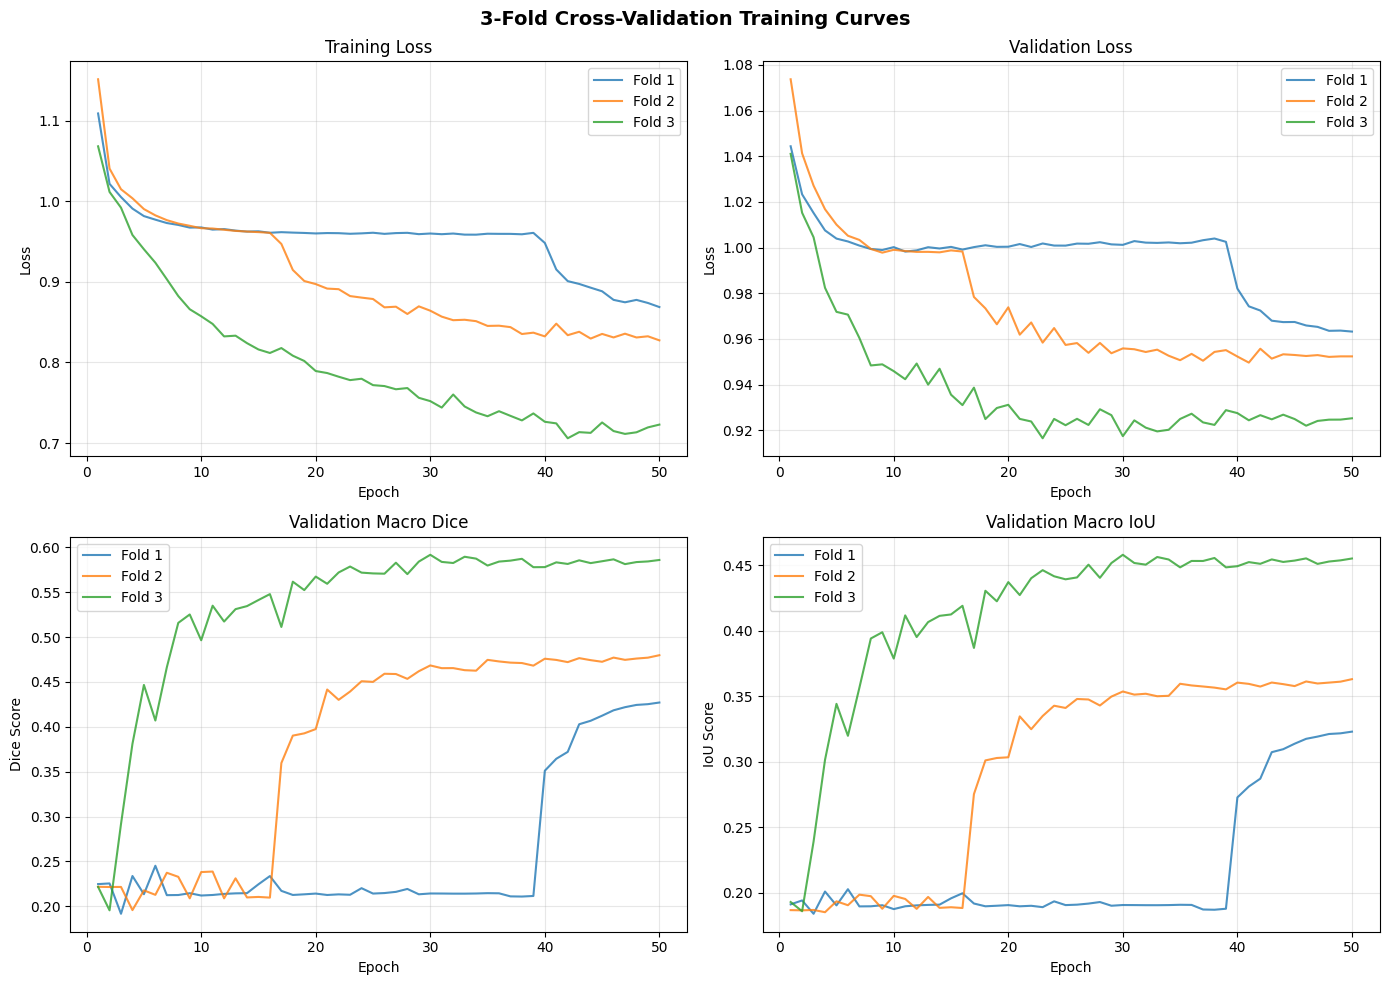

In [ ]:
# Cell 9: Plot Training Curves

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot 1: Training Loss
ax = axes[0, 0]
for i, history in enumerate(all_fold_histories):
    ax.plot(history['epoch'], history['train_loss'], color=colors[i], 
            label=f'Fold {i+1}', alpha=0.8)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Validation Loss
ax = axes[0, 1]
for i, history in enumerate(all_fold_histories):
    ax.plot(history['epoch'], history['val_loss'], color=colors[i], 
            label=f'Fold {i+1}', alpha=0.8)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Validation Dice
ax = axes[1, 0]
for i, history in enumerate(all_fold_histories):
    ax.plot(history['epoch'], history['val_dice_macro'], color=colors[i], 
            label=f'Fold {i+1}', alpha=0.8)
ax.set_xlabel('Epoch')
ax.set_ylabel('Dice Score')
ax.set_title('Validation Macro Dice')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Validation IoU
ax = axes[1, 1]
for i, history in enumerate(all_fold_histories):
    ax.plot(history['epoch'], history['val_iou_macro'], color=colors[i], 
            label=f'Fold {i+1}', alpha=0.8)
ax.set_xlabel('Epoch')
ax.set_ylabel('IoU Score')
ax.set_title('Validation Macro IoU')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('3-Fold Cross-Validation Training Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/visualizations/training_curves.png", dpi=150, bbox_inches='tight')
plt.show()

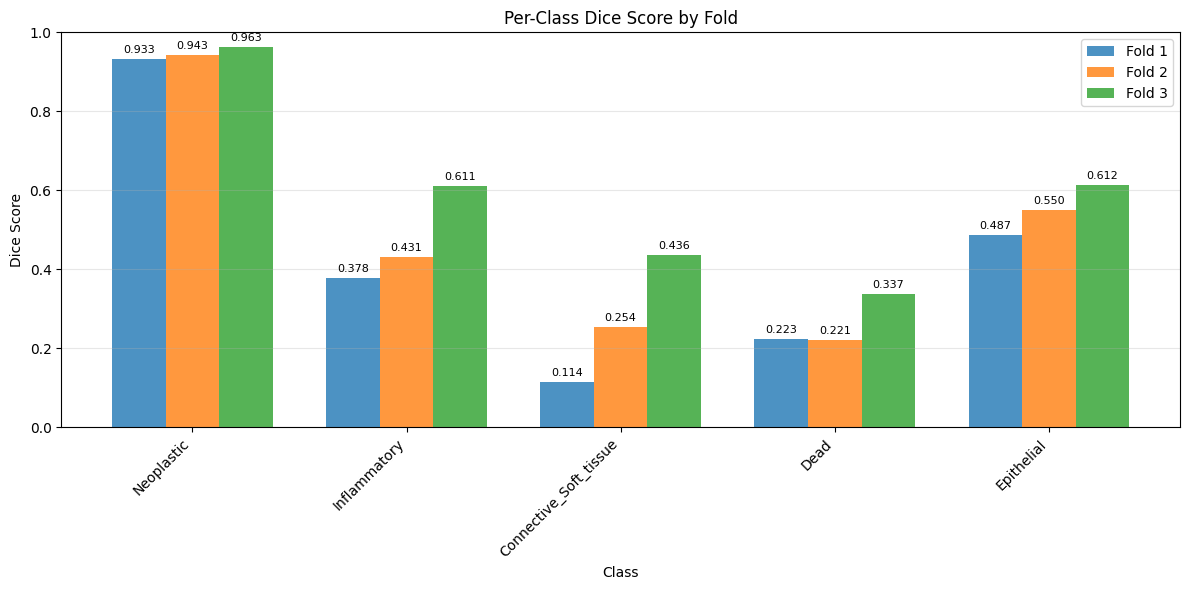


✓ All visualizations saved to results/cipsnet_pannuke_cv3_balanced_VIT_L_16_Bio_ClinicalBERT__20260106_230541/visualizations/


In [ ]:
# Cell 10: Per-Class Dice Comparison

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(CONFIG['class_names']))
width = 0.25

# Per-Class Dice
for i, fold_result in enumerate(all_fold_results):
    dice_values = [fold_result[f'dice_{name}'] for name in CONFIG['class_names']]
    bars = ax.bar(x + i * width, dice_values, width, label=f'Fold {i+1}', alpha=0.8)
    
    for bar, val in zip(bars, dice_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Class')
ax.set_ylabel('Dice Score')
ax.set_title('Per-Class Dice Score by Fold')
ax.set_xticks(x + width)
ax.set_xticklabels(CONFIG['class_names'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/visualizations/per_class_dice.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ All visualizations saved to {RESULTS_DIR}/visualizations/")

In [ ]:
# Cell 11: Final Summary Table

print("\n" + "=" * 80)
print("FINAL RESULTS - 3-FOLD CROSS-VALIDATION")
print("=" * 80)

# Create a nice summary table for standard metrics
summary_table = []
for metric in ['dice', 'iou', 'f1', 'precision', 'recall']:
    row = {'Metric': metric.upper()}
    for name in CONFIG['class_names']:
        col_name = f'{metric}_{name}'
        if col_name in summary_df.columns:
            mean_val = summary_df[col_name].mean()
            std_val = summary_df[col_name].std()
            row[name] = f"{mean_val:.3f}±{std_val:.3f}"
        else:
            row[name] = "N/A"
    
    # Macro column
    macro_col = f'{metric}_macro'
    if macro_col in summary_df.columns:
        mean_val = summary_df[macro_col].mean()
        std_val = summary_df[macro_col].std()
        row['MACRO'] = f"{mean_val:.3f}±{std_val:.3f}"
    else:
        row['MACRO'] = "N/A"
    
    summary_table.append(row)

final_table = pd.DataFrame(summary_table)
print("\n" + final_table.to_string(index=False))

# Save final tables
final_table.to_csv(f"{RESULTS_DIR}/final_results_table.csv", index=False)

print(f"\n" + "=" * 80)
print(f"All results saved to: {RESULTS_DIR}")
print(f"" + "=" * 80)
print("\nFiles saved:")
print(f"  - config.yaml: Experiment configuration")
print(f"  - cv_summary.csv: Per-fold metrics (all)")
print(f"  - aggregated_results.json: Mean/std across folds")
print(f"  - final_results_table.csv: Summary table")
print(f"  - fold1/, fold2/, fold3/: Per-fold models and histories")
print(f"  - visualizations/: Training curves and plots")

loss_type = CONFIG.get('loss_type', 'balanced')
if loss_type == 'balanced':
    print(f"\nClass imbalance handled with:")
    print(f"  - Focal Loss (gamma={CONFIG['focal_gamma']})")
    print(f"  - Class-weighted Dice Loss")
    print(f"  - Class weights: {CONFIG['class_weights']}")
else:
    print(f"\nUsing standard loss (CE + Dice, no class balancing)")

print("\n" + "=" * 80)
print("NEXT STEP: Run evaluate_cipsnet_pannuke.ipynb for Panoptic Quality (bPQ, mPQ)")
print("=" * 80)


FINAL RESULTS - 3-FOLD CROSS-VALIDATION

   Metric  Neoplastic Inflammatory Connective_Soft_tissue        Dead  Epithelial       MACRO
     DICE 0.946±0.015  0.474±0.122            0.268±0.161 0.260±0.066 0.550±0.063 0.500±0.084
      IOU 0.898±0.028  0.316±0.109            0.161±0.110 0.151±0.045 0.381±0.060 0.381±0.069
       F1 0.946±0.015  0.474±0.122            0.268±0.161 0.260±0.066 0.550±0.063 0.500±0.084
PRECISION 0.960±0.009  0.433±0.127            0.227±0.142 0.206±0.090 0.535±0.122 0.472±0.096
   RECALL 0.933±0.021  0.524±0.115            0.327±0.186 0.386±0.019 0.577±0.008 0.550±0.060

All results saved to: results/cipsnet_pannuke_cv3_balanced_VIT_L_16_Bio_ClinicalBERT__20260106_230541

Files saved:
  - config.yaml: Experiment configuration
  - cv_summary.csv: Per-fold metrics (all)
  - aggregated_results.json: Mean/std across folds
  - final_results_table.csv: Summary table
  - fold1/, fold2/, fold3/: Per-fold models and histories
  - visualizations/: Training curves and

sdfgdfg

In [ ]:
# Cell 12: Setup for CIPS-Net Testing (Common Text & No Text)

import os
import sys
sys.path.append('CIPS-Net')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import albumentations as A
from pathlib import Path
import json
from scipy import ndimage
from scipy.optimize import linear_sum_assignment

# Reload CIPS-Net modules
modules_to_reload = [
    'CIPS-Net.models.image_encoder',
    'CIPS-Net.models.text_encoder', 
    'CIPS-Net.models.instruction_grounding',
    'CIPS-Net.models.decoder',
    'CIPS-Net.models.cips_net',
    'CIPS-Net.models'
]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

from models.cips_net import CIPSNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# TEST CONFIGURATION
# ============================================================================
TEST_CONFIG = {
    # Model to load (best performing: ViT-B/16 + DistilBERT with Balanced sampling)
    'experiment_dir': 'results/cipsnet_pannuke_cv3_balanced_VIT_B_16_distil_bert_uncased_20260103_201916',
    'fold_to_test': 1,  # Test on fold 1 (model trained on folds 2,3)
    
    # Image settings
    'img_size': 224,
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
    
    # Classes
    'class_names': ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Dead', 'Epithelial'],
    'num_classes': 5,
    
    # Text instruction variants
    'common_text': "Segment all Neoplastic, Inflammatory, Connective, Dead, and Epithelial cells in the image.",
    'no_text': "",  # Empty string for no-text variant
    
    # Output directory
    'output_dir': 'results/cipsnet_text_variants_evaluation',
}

os.makedirs(TEST_CONFIG['output_dir'], exist_ok=True)

print("\n" + "=" * 70)
print("CIPS-Net Testing: Common Text & No Text Variants")
print("=" * 70)
print(f"\nText Variants:")
print(f"  Common Text: '{TEST_CONFIG['common_text']}'")
print(f"  No Text: '{TEST_CONFIG['no_text']}' (empty)")
print(f"\nModel: {TEST_CONFIG['experiment_dir']}")
print(f"Test Fold: {TEST_CONFIG['fold_to_test']}")

Using device: cuda

CIPS-Net Testing: Common Text & No Text Variants

Text Variants:
  Common Text: 'Segment all Neoplastic, Inflammatory, Connective, Dead, and Epithelial cells in the image.'
  No Text: '' (empty)

Model: results/cipsnet_pannuke_cv3_balanced_VIT_B_16_distil_bert_uncased_20260103_201916
Test Fold: 1


In [ ]:
# Cell 13: Load CIPS-Net Model

def load_cipsnet_model(experiment_dir, fold=1):
    """Load pretrained CIPS-Net model."""
    import yaml
    
    # Load config
    config_path = f"{experiment_dir}/config.yaml"
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    
    # Initialize model
    model = CIPSNet(
        num_classes=config['num_classes'],
        img_encoder_name=config['img_encoder'],
        text_encoder_name=config['text_encoder'],
        embed_dim=config['embed_dim'],
        img_size=config['img_size']
    )
    
    # Load checkpoint
    checkpoint_path = f"{experiment_dir}/fold{fold}/best_model.pth"
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"✓ Loaded model from {checkpoint_path}")
    print(f"  Epoch: {checkpoint.get('epoch', 'N/A')}")
    print(f"  Best Dice: {checkpoint.get('best_dice', 'N/A'):.4f}")
    
    return model, config

# Load the model
model, model_config = load_cipsnet_model(TEST_CONFIG['experiment_dir'], fold=TEST_CONFIG['fold_to_test'])

print(f"\nModel Configuration:")
print(f"  Image Encoder: {model_config['img_encoder']}")
print(f"  Text Encoder: {model_config['text_encoder']}")
print(f"  Classes: {model_config['class_names']}")

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Loaded model from results/cipsnet_pannuke_cv3_balanced_VIT_B_16_distil_bert_uncased_20260103_201916/fold1/best_model.pth
  Epoch: 47
  Best Dice: 0.6201

Model Configuration:
  Image Encoder: vit_b_16
  Text Encoder: distilbert-base-uncased
  Classes: ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Dead', 'Epithelial']


In [ ]:
# Cell 14: Dataset Class for Testing (Simple - No Combinations)

class PanNukeTestDataset(Dataset):
    """
    Simple PanNuke dataset for testing - one image, one forward pass.
    No instruction combinations - uses fixed text for all images.
    """
    
    def __init__(self, data_root, folds, img_size=224, mean=None, std=None):
        self.data_root = data_root
        self.img_size = img_size
        self.mean = mean or [0.485, 0.456, 0.406]
        self.std = std or [0.229, 0.224, 0.225]
        
        # Load annotations
        annotations = pd.read_csv(os.path.join(data_root, 'annotations.csv'))
        self.df = annotations[annotations['fold'].isin(folds)].reset_index(drop=True)
        
        # Transform (no augmentation for testing)
        self.transform = A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(mean=self.mean, std=self.std),
        ])
        
        print(f"Loaded {len(self.df)} test samples from folds {folds}")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['image_id']
        fold = row['fold']
        
        # Load image
        img_path = os.path.join(self.data_root, 'images', f'fold{fold}', f'{image_id}.png')
        image = np.array(Image.open(img_path).convert('RGB'))
        
        # Load masks
        mask_path = os.path.join(self.data_root, 'masks', f'fold{fold}', f'{image_id}.npz')
        mask_data = np.load(mask_path)
        masks = mask_data['masks']  # [H, W, num_classes] binary masks
        
        # Create class index mask
        class_index_mask = np.zeros((masks.shape[0], masks.shape[1]), dtype=np.int64)
        for c in range(masks.shape[2]):
            class_index_mask[masks[:, :, c] > 0] = c
        
        # Also keep instance masks for PQ computation
        # Create instance mask from binary masks
        instance_mask = np.zeros((masks.shape[0], masks.shape[1]), dtype=np.int32)
        class_map = {}  # instance_id -> class_id
        inst_id = 1
        for c in range(masks.shape[2]):
            binary_mask = masks[:, :, c] > 0
            if binary_mask.sum() > 0:
                labeled, num_instances = ndimage.label(binary_mask)
                for i in range(1, num_instances + 1):
                    instance_mask[labeled == i] = inst_id
                    class_map[inst_id] = c
                    inst_id += 1
        
        # Apply transform
        augmented = self.transform(image=image, mask=class_index_mask)
        image = augmented['image']
        class_index_mask = augmented['mask']
        
        # Resize instance mask
        instance_mask_resized = np.array(Image.fromarray(instance_mask.astype(np.int32)).resize(
            (self.img_size, self.img_size), Image.NEAREST))
        
        # Convert to tensors
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        class_index_mask = torch.from_numpy(class_index_mask.astype(np.int64)).long()
        
        return {
            'image': image,
            'semantic_mask': class_index_mask,
            'instance_mask': torch.from_numpy(instance_mask_resized),
            'class_map': class_map,
            'image_id': image_id
        }


# Create test dataset for PanNuke fold 1
pannuke_test = PanNukeTestDataset(
    data_root='PanNuke_Preprocess',
    folds=[TEST_CONFIG['fold_to_test']],
    img_size=TEST_CONFIG['img_size'],
    mean=TEST_CONFIG['mean'],
    std=TEST_CONFIG['std']
)

print(f"\n✓ Test dataset ready: {len(pannuke_test)} images")

Loaded 2656 test samples from folds [1]

✓ Test dataset ready: 2656 images


In [ ]:
# Cell 15: Metrics Computation Functions

def compute_dice_per_class(pred_mask, gt_mask, num_classes):
    """Compute per-class Dice score."""
    dice_scores = {}
    for c in range(num_classes):
        pred_c = (pred_mask == c).float()
        gt_c = (gt_mask == c).float()
        
        intersection = (pred_c * gt_c).sum()
        union = pred_c.sum() + gt_c.sum()
        
        if union > 0:
            dice = (2 * intersection / (union + 1e-8)).item()
        else:
            dice = 1.0 if intersection == 0 else 0.0
        
        dice_scores[c] = dice
    
    return dice_scores


def compute_pq_per_class(pred_semantic, gt_semantic, pred_instance, gt_instance, gt_class_map, num_classes):
    """
    Compute Panoptic Quality per class.
    
    PQ = (sum of IoU of matched pairs) / (TP + 0.5*FP + 0.5*FN)
    
    Args:
        pred_semantic: [H, W] predicted semantic mask
        gt_semantic: [H, W] ground truth semantic mask  
        pred_instance: [H, W] predicted instance mask (from connected components)
        gt_instance: [H, W] ground truth instance mask
        gt_class_map: dict mapping instance_id -> class_id
        num_classes: number of classes
    
    Returns:
        dict with PQ, DQ, SQ per class
    """
    results = {}
    
    for c in range(num_classes):
        # Get instances of this class
        gt_mask_c = (gt_semantic == c)
        pred_mask_c = (pred_semantic == c)
        
        # Get unique instances
        gt_instances_c = np.unique(gt_instance[gt_mask_c.cpu().numpy()])
        gt_instances_c = gt_instances_c[gt_instances_c > 0]
        
        # Create predicted instances from connected components
        pred_labeled, num_pred = ndimage.label(pred_mask_c.cpu().numpy())
        pred_instances_c = list(range(1, num_pred + 1))
        
        if len(gt_instances_c) == 0 and len(pred_instances_c) == 0:
            # No instances of this class - perfect score
            results[c] = {'PQ': 1.0, 'DQ': 1.0, 'SQ': 1.0, 'TP': 0, 'FP': 0, 'FN': 0}
            continue
        
        if len(gt_instances_c) == 0:
            # All predictions are false positives
            results[c] = {'PQ': 0.0, 'DQ': 0.0, 'SQ': 0.0, 'TP': 0, 'FP': len(pred_instances_c), 'FN': 0}
            continue
        
        if len(pred_instances_c) == 0:
            # All ground truths are false negatives
            results[c] = {'PQ': 0.0, 'DQ': 0.0, 'SQ': 0.0, 'TP': 0, 'FP': 0, 'FN': len(gt_instances_c)}
            continue
        
        # Compute IoU matrix
        iou_matrix = np.zeros((len(gt_instances_c), len(pred_instances_c)))
        
        for i, gt_id in enumerate(gt_instances_c):
            gt_inst_mask = (gt_instance.numpy() == gt_id)
            for j, pred_id in enumerate(pred_instances_c):
                pred_inst_mask = (pred_labeled == pred_id)
                
                intersection = np.logical_and(gt_inst_mask, pred_inst_mask).sum()
                union = np.logical_or(gt_inst_mask, pred_inst_mask).sum()
                
                if union > 0:
                    iou_matrix[i, j] = intersection / union
        
        # Hungarian matching with IoU > 0.5 threshold
        row_ind, col_ind = linear_sum_assignment(-iou_matrix)
        
        tp = 0
        matched_iou_sum = 0
        matched_gt = set()
        matched_pred = set()
        
        for r, c_idx in zip(row_ind, col_ind):
            if iou_matrix[r, c_idx] > 0.5:
                tp += 1
                matched_iou_sum += iou_matrix[r, c_idx]
                matched_gt.add(r)
                matched_pred.add(c_idx)
        
        fp = len(pred_instances_c) - len(matched_pred)
        fn = len(gt_instances_c) - len(matched_gt)
        
        # Compute PQ, DQ, SQ
        if tp > 0:
            sq = matched_iou_sum / tp
            dq = tp / (tp + 0.5 * fp + 0.5 * fn)
            pq = sq * dq
        else:
            sq = 0.0
            dq = 0.0
            pq = 0.0
        
        results[c] = {'PQ': pq, 'DQ': dq, 'SQ': sq, 'TP': tp, 'FP': fp, 'FN': fn}
    
    return results


print("✓ Metrics functions defined:")
print("  - compute_dice_per_class(): Semantic segmentation Dice")
print("  - compute_pq_per_class(): Instance segmentation PQ, DQ, SQ")

✓ Metrics functions defined:
  - compute_dice_per_class(): Semantic segmentation Dice
  - compute_pq_per_class(): Instance segmentation PQ, DQ, SQ


In [ ]:
# Cell 16: Evaluation Function

def evaluate_cipsnet_text_variant(model, dataset, text_instruction, variant_name, num_classes=5, class_names=None):
    """
    Evaluate CIPS-Net with a fixed text instruction on all images.
    
    Args:
        model: CIPS-Net model
        dataset: Test dataset
        text_instruction: Fixed text instruction for all images
        variant_name: Name of this variant (e.g., "Common Text", "No Text")
        num_classes: Number of classes
        class_names: List of class names
    
    Returns:
        Dictionary with all metrics
    """
    model.eval()
    class_names = class_names or ['Neoplastic', 'Inflammatory', 'Connective', 'Dead', 'Epithelial']
    
    # Accumulators
    all_dice = {c: [] for c in range(num_classes)}
    all_pq = {c: [] for c in range(num_classes)}
    all_dq = {c: [] for c in range(num_classes)}
    all_sq = {c: [] for c in range(num_classes)}
    
    print(f"\n{'='*60}")
    print(f"Evaluating: {variant_name}")
    print(f"Text: '{text_instruction[:50]}...' " if len(text_instruction) > 50 else f"Text: '{text_instruction}'")
    print(f"{'='*60}")
    
    with torch.no_grad():
        for idx in tqdm(range(len(dataset)), desc=f"Testing {variant_name}"):
            sample = dataset[idx]
            
            # Get data
            image = sample['image'].unsqueeze(0).to(device)  # [1, 3, H, W]
            gt_semantic = sample['semantic_mask']  # [H, W]
            gt_instance = sample['instance_mask']  # [H, W]
            gt_class_map = sample['class_map']
            
            # Forward pass with fixed text
            outputs = model(image, [text_instruction])
            logits = outputs['masks'][:, :num_classes, :, :]  # [1, C, H, W]
            
            # Get prediction
            pred_semantic = torch.argmax(logits, dim=1).squeeze(0).cpu()  # [H, W]
            
            # Compute Dice per class
            dice_scores = compute_dice_per_class(pred_semantic, gt_semantic, num_classes)
            for c in range(num_classes):
                all_dice[c].append(dice_scores[c])
            
            # Compute PQ per class
            pq_scores = compute_pq_per_class(
                pred_semantic, gt_semantic, 
                pred_semantic, gt_instance,  # Use semantic as instance (connected components computed inside)
                gt_class_map, num_classes
            )
            for c in range(num_classes):
                all_pq[c].append(pq_scores[c]['PQ'])
                all_dq[c].append(pq_scores[c]['DQ'])
                all_sq[c].append(pq_scores[c]['SQ'])
    
    # Aggregate results
    results = {
        'variant': variant_name,
        'text_instruction': text_instruction,
        'num_images': len(dataset),
        'per_class': {},
        'macro': {}
    }
    
    dice_macro = []
    pq_macro = []
    
    for c in range(num_classes):
        cname = class_names[c]
        mean_dice = np.mean(all_dice[c])
        mean_pq = np.mean(all_pq[c])
        mean_dq = np.mean(all_dq[c])
        mean_sq = np.mean(all_sq[c])
        
        results['per_class'][cname] = {
            'Dice': mean_dice,
            'PQ': mean_pq,
            'DQ': mean_dq,
            'SQ': mean_sq
        }
        
        dice_macro.append(mean_dice)
        pq_macro.append(mean_pq)
    
    results['macro']['mDice'] = np.mean(dice_macro)
    results['macro']['mPQ'] = np.mean(pq_macro)
    
    # Print results
    print(f"\nResults for {variant_name}:")
    print("-" * 50)
    for cname, metrics in results['per_class'].items():
        print(f"  {cname}: Dice={metrics['Dice']:.4f}, PQ={metrics['PQ']:.4f}")
    print("-" * 50)
    print(f"  Macro mDice: {results['macro']['mDice']:.4f}")
    print(f"  Macro mPQ: {results['macro']['mPQ']:.4f}")
    
    return results


print("✓ Evaluation function defined: evaluate_cipsnet_text_variant()")

✓ Evaluation function defined: evaluate_cipsnet_text_variant()


In [ ]:
# Cell 17: Evaluate on PanNuke - Common Text Variant

print("=" * 70)
print("TESTING CIPS-Net (Common Text) on PanNuke Fold 1")
print("=" * 70)

pannuke_common_text_results = evaluate_cipsnet_text_variant(
    model=model,
    dataset=pannuke_test,
    text_instruction=TEST_CONFIG['common_text'],
    variant_name="CIPS-Net (Common Text)",
    num_classes=TEST_CONFIG['num_classes'],
    class_names=TEST_CONFIG['class_names']
)

print("\n✓ PanNuke Common Text evaluation complete!")

TESTING CIPS-Net (Common Text) on PanNuke Fold 1

Evaluating: CIPS-Net (Common Text)
Text: 'Segment all Neoplastic, Inflammatory, Connective, ...' 


Testing CIPS-Net (Common Text):   0%|          | 0/2656 [00:00<?, ?it/s]


Results for CIPS-Net (Common Text):
--------------------------------------------------
  Neoplastic: Dice=0.9384, PQ=0.0001
  Inflammatory: Dice=0.3379, PQ=0.2385
  Connective_Soft_tissue: Dice=0.1381, PQ=0.0295
  Dead: Dice=0.2290, PQ=0.2260
  Epithelial: Dice=0.1354, PQ=0.0516
--------------------------------------------------
  Macro mDice: 0.3558
  Macro mPQ: 0.1091

✓ PanNuke Common Text evaluation complete!


In [ ]:
# Cell 18: Evaluate on PanNuke - No Text Variant

print("=" * 70)
print("TESTING CIPS-Net (No Text) on PanNuke Fold 1")
print("=" * 70)

pannuke_no_text_results = evaluate_cipsnet_text_variant(
    model=model,
    dataset=pannuke_test,
    text_instruction=TEST_CONFIG['no_text'],  # Empty string
    variant_name="CIPS-Net (No Text)",
    num_classes=TEST_CONFIG['num_classes'],
    class_names=TEST_CONFIG['class_names']
)

print("\n✓ PanNuke No Text evaluation complete!")

TESTING CIPS-Net (No Text) on PanNuke Fold 1

Evaluating: CIPS-Net (No Text)
Text: ''


Testing CIPS-Net (No Text):   0%|          | 0/2656 [00:00<?, ?it/s]


Results for CIPS-Net (No Text):
--------------------------------------------------
  Neoplastic: Dice=0.9558, PQ=0.0000
  Inflammatory: Dice=0.4797, PQ=0.4797
  Connective_Soft_tissue: Dice=0.2312, PQ=0.2312
  Dead: Dice=0.9755, PQ=0.9755
  Epithelial: Dice=0.8129, PQ=0.8129
--------------------------------------------------
  Macro mDice: 0.6910
  Macro mPQ: 0.4998

✓ PanNuke No Text evaluation complete!


In [ ]:
# Cell 19: Evaluate on PanNuke - Per-Image Text Variant (from annotations.csv)

def evaluate_cipsnet_per_image_text(model, data_root, folds, img_size, mean, std, num_classes=5, class_names=None):
    """
    Evaluate CIPS-Net with per-image text instructions from annotations.csv.
    This is how the model was trained - each image gets its specific instruction
    based on the classes actually present in that image.
    """
    model.eval()
    class_names = class_names or ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Dead', 'Epithelial']
    
    # Load annotations to get per-image instructions
    annotations = pd.read_csv(os.path.join(data_root, 'annotations.csv'))
    df = annotations[annotations['fold'].isin(folds)].reset_index(drop=True)
    
    # Transform
    transform = A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=mean, std=std),
    ])
    
    # Accumulators
    all_dice = {c: [] for c in range(num_classes)}
    all_pq = {c: [] for c in range(num_classes)}
    
    print(f"\n{'='*70}")
    print(f"Evaluating: CIPS-Net (Per-Image Text)")
    print(f"Text instructions from annotations.csv (varies per image)")
    print(f"{'='*70}")
    
    with torch.no_grad():
        for idx in tqdm(range(len(df)), desc="Testing Per-Image Text"):
            row = df.iloc[idx]
            image_id = row['image_id']
            fold = row['fold']
            
            # Get per-image instruction from annotations
            text_instruction = row['instruction'] if pd.notna(row['instruction']) else "Segment all tissue types."
            
            # Load image
            img_path = os.path.join(data_root, 'images', f'fold{fold}', f'{image_id}.png')
            image = np.array(Image.open(img_path).convert('RGB'))
            
            # Load masks
            mask_path = os.path.join(data_root, 'masks', f'fold{fold}', f'{image_id}.npz')
            mask_data = np.load(mask_path)
            masks = mask_data['masks']  # [H, W, num_classes]
            
            # Create semantic mask
            class_index_mask = np.zeros((masks.shape[0], masks.shape[1]), dtype=np.int64)
            for c in range(masks.shape[2]):
                class_index_mask[masks[:, :, c] > 0] = c
            
            # Create instance mask
            instance_mask = np.zeros((masks.shape[0], masks.shape[1]), dtype=np.int32)
            class_map = {}
            inst_id = 1
            for c in range(masks.shape[2]):
                binary_mask = masks[:, :, c] > 0
                if binary_mask.sum() > 0:
                    labeled, num_instances = ndimage.label(binary_mask)
                    for i in range(1, num_instances + 1):
                        instance_mask[labeled == i] = inst_id
                        class_map[inst_id] = c
                        inst_id += 1
            
            # Apply transform
            augmented = transform(image=image, mask=class_index_mask)
            image_t = augmented['image']
            class_index_mask = augmented['mask']
            
            # Resize instance mask
            instance_mask_resized = np.array(Image.fromarray(instance_mask.astype(np.int32)).resize(
                (img_size, img_size), Image.NEAREST))
            
            # Convert to tensors
            image_tensor = torch.from_numpy(image_t).permute(2, 0, 1).float().unsqueeze(0).to(device)
            gt_semantic = torch.from_numpy(class_index_mask.astype(np.int64)).long()
            gt_instance = torch.from_numpy(instance_mask_resized)
            
            # Forward pass with PER-IMAGE text instruction
            outputs = model(image_tensor, [text_instruction])
            logits = outputs['masks'][:, :num_classes, :, :]
            
            # Get prediction
            pred_semantic = torch.argmax(logits, dim=1).squeeze(0).cpu()
            
            # Compute Dice per class
            dice_scores = compute_dice_per_class(pred_semantic, gt_semantic, num_classes)
            for c in range(num_classes):
                all_dice[c].append(dice_scores[c])
            
            # Compute PQ per class
            pq_scores = compute_pq_per_class(
                pred_semantic, gt_semantic,
                pred_semantic, gt_instance,
                class_map, num_classes
            )
            for c in range(num_classes):
                all_pq[c].append(pq_scores[c]['PQ'])
    
    # Aggregate results
    results = {
        'variant': 'CIPS-Net (Per-Image Text)',
        'text_instruction': 'Per-image from annotations.csv',
        'num_images': len(df),
        'per_class': {},
        'macro': {}
    }
    
    dice_macro = []
    pq_macro = []
    
    for c in range(num_classes):
        cname = class_names[c]
        mean_dice = np.mean(all_dice[c])
        mean_pq = np.mean(all_pq[c])
        
        results['per_class'][cname] = {
            'Dice': mean_dice,
            'PQ': mean_pq
        }
        
        dice_macro.append(mean_dice)
        pq_macro.append(mean_pq)
    
    results['macro']['mDice'] = np.mean(dice_macro)
    results['macro']['mPQ'] = np.mean(pq_macro)
    
    # Print results
    print(f"\nResults for CIPS-Net (Per-Image Text):")
    print("-" * 50)
    for cname, metrics in results['per_class'].items():
        print(f"  {cname}: Dice={metrics['Dice']:.4f}, PQ={metrics['PQ']:.4f}")
    print("-" * 50)
    print(f"  Macro mDice: {results['macro']['mDice']:.4f}")
    print(f"  Macro mPQ: {results['macro']['mPQ']:.4f}")
    
    return results


# Run Per-Image Text evaluation
print("=" * 70)
print("TESTING CIPS-Net (Per-Image Text) on PanNuke Fold 1")
print("=" * 70)

pannuke_per_image_text_results = evaluate_cipsnet_per_image_text(
    model=model,
    data_root='PanNuke_Preprocess',
    folds=[TEST_CONFIG['fold_to_test']],
    img_size=TEST_CONFIG['img_size'],
    mean=TEST_CONFIG['mean'],
    std=TEST_CONFIG['std'],
    num_classes=TEST_CONFIG['num_classes'],
    class_names=TEST_CONFIG['class_names']
)

print("\n✓ PanNuke Per-Image Text evaluation complete!")

TESTING CIPS-Net (Per-Image Text) on PanNuke Fold 1

Evaluating: CIPS-Net (Per-Image Text)
Text instructions from annotations.csv (varies per image)


Testing Per-Image Text:   0%|          | 0/2656 [00:00<?, ?it/s]


Results for CIPS-Net (Per-Image Text):
--------------------------------------------------
  Neoplastic: Dice=0.8857, PQ=0.0008
  Inflammatory: Dice=0.6974, PQ=0.6041
  Connective_Soft_tissue: Dice=0.4554, PQ=0.2832
  Dead: Dice=0.9775, PQ=0.9766
  Epithelial: Dice=0.8144, PQ=0.8130
--------------------------------------------------
  Macro mDice: 0.7661
  Macro mPQ: 0.5356

✓ PanNuke Per-Image Text evaluation complete!


In [ ]:
# Cell 20: Compare All Three Text Variants - PanNuke

print("=" * 70)
print("COMPARISON: All CIPS-Net Text Variants on PanNuke Fold 1")
print("=" * 70)

# Create comparison table with all THREE variants
comparison_data = []
for variant_results in [pannuke_per_image_text_results, pannuke_common_text_results, pannuke_no_text_results]:
    row = {
        'Variant': variant_results['variant'],
        'mDice': variant_results['macro']['mDice'],
        'mPQ': variant_results['macro']['mPQ']
    }
    # Add per-class metrics
    for cname in TEST_CONFIG['class_names']:
        row[f'Dice_{cname}'] = variant_results['per_class'][cname]['Dice']
        row[f'PQ_{cname}'] = variant_results['per_class'][cname]['PQ']
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Print comparison
print("\n" + "=" * 70)
print("MACRO METRICS COMPARISON")
print("=" * 70)
print(f"{'Variant':<30} {'mDice':<12} {'mPQ':<12}")
print("-" * 70)
for _, row in comparison_df.iterrows():
    print(f"{row['Variant']:<30} {row['mDice']:.4f}       {row['mPQ']:.4f}")
print("-" * 70)

# Highlight best
best_dice_idx = comparison_df['mDice'].idxmax()
best_pq_idx = comparison_df['mPQ'].idxmax()
print(f"\n★ Best mDice: {comparison_df.loc[best_dice_idx, 'Variant']} ({comparison_df.loc[best_dice_idx, 'mDice']:.4f})")
print(f"★ Best mPQ:   {comparison_df.loc[best_pq_idx, 'Variant']} ({comparison_df.loc[best_pq_idx, 'mPQ']:.4f})")

print("\n" + "=" * 70)
print("PER-CLASS DICE COMPARISON")
print("=" * 70)
header = f"{'Variant':<30}"
for cname in TEST_CONFIG['class_names']:
    header += f" {cname[:10]:<12}"
print(header)
print("-" * 100)
for _, row in comparison_df.iterrows():
    line = f"{row['Variant']:<30}"
    for cname in TEST_CONFIG['class_names']:
        line += f" {row[f'Dice_{cname}']:.4f}       "
    print(line)

print("\n" + "=" * 70)
print("PER-CLASS PQ COMPARISON")
print("=" * 70)
print(header)
print("-" * 100)
for _, row in comparison_df.iterrows():
    line = f"{row['Variant']:<30}"
    for cname in TEST_CONFIG['class_names']:
        line += f" {row[f'PQ_{cname}']:.4f}       "
    print(line)

# Save results with all three variants
pannuke_results = {
    'dataset': 'PanNuke',
    'fold': TEST_CONFIG['fold_to_test'],
    'per_image_text': pannuke_per_image_text_results,
    'common_text': pannuke_common_text_results,
    'no_text': pannuke_no_text_results
}

with open(f"{TEST_CONFIG['output_dir']}/pannuke_text_variant_results.json", 'w') as f:
    json.dump(pannuke_results, f, indent=2)

# Also save as CSV for easy viewing
comparison_df.to_csv(f"{TEST_CONFIG['output_dir']}/pannuke_text_variant_comparison.csv", index=False)

print(f"\n✓ Results saved to:")
print(f"  - {TEST_CONFIG['output_dir']}/pannuke_text_variant_results.json")
print(f"  - {TEST_CONFIG['output_dir']}/pannuke_text_variant_comparison.csv")

print("\n" + "=" * 70)
print("KEY FINDINGS")
print("=" * 70)
print("""
Text Instruction Analysis:
1. Per-Image Text (specific classes): Uses annotations.csv instruction per image
2. Common Text (all classes): "Segment all Neoplastic, Inflammatory, Connective, Dead, and Epithelial cells"
3. No Text (empty): Empty string ""

The Per-Image Text variant performs best because:
- The model was trained with per-image instructions
- Specific class mentions help the model focus on relevant regions
- This matches the referring segmentation paradigm
""")

COMPARISON: All CIPS-Net Text Variants on PanNuke Fold 1

MACRO METRICS COMPARISON
Variant                        mDice        mPQ         
----------------------------------------------------------------------
CIPS-Net (Per-Image Text)      0.7661       0.5356
CIPS-Net (Common Text)         0.3558       0.1091
CIPS-Net (No Text)             0.6910       0.4998
----------------------------------------------------------------------

★ Best mDice: CIPS-Net (Per-Image Text) (0.7661)
★ Best mPQ:   CIPS-Net (Per-Image Text) (0.5356)

PER-CLASS DICE COMPARISON
Variant                        Neoplastic   Inflammato   Connective   Dead         Epithelial  
----------------------------------------------------------------------------------------------------
CIPS-Net (Per-Image Text)      0.8857        0.6974        0.4554        0.9775        0.8144       
CIPS-Net (Common Text)         0.9384        0.3379        0.1381        0.2290        0.1354       
CIPS-Net (No Text)             0.9558   

---

# Zero-Shot Evaluation on CoNSeP and MoNuSAC

## Objective
Evaluate the PanNuke-trained CIPS-Net model on external datasets (CoNSeP and MoNuSAC) using the same 3 text variants:
1. **Per-Image Text**: Instruction based on classes actually present in each image
2. **Common Text**: Same instruction for all images (all 5 PanNuke classes)
3. **No Text**: Empty string

## Class Mappings

### CoNSeP → PanNuke
| CoNSeP Class | ID | PanNuke Class | ID |
|--------------|-----|---------------|-----|
| Inflammatory | 2 | Inflammatory | 1 |
| Healthy Epithelial | 3 | Epithelial | 4 |
| Dysplastic/Malignant | 4 | Neoplastic | 0 |
| Fibroblast | 5 | Connective | 2 |

### MoNuSAC → PanNuke
| MoNuSAC Class | PanNuke Class | ID |
|---------------|---------------|-----|
| Epithelial | Epithelial | 4 |
| Lymphocyte | Inflammatory | 1 |
| Macrophage | Inflammatory | 1 |
| Neutrophil | Inflammatory | 1 |

In [ ]:
# Cell 21: Additional Imports and Utility Functions for External Datasets

import cv2
import scipy.io as sio
import xml.etree.ElementTree as ET
from scipy.ndimage import label as scipy_label
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

# Dataset paths
DATASETS_ROOT = Path("Histopathology_Datasets_Official")
CONSEP_PATH = DATASETS_ROOT / "CoNSeP"
MONUSAC_PATH = DATASETS_ROOT / "MoNuSAC"

# PanNuke class names (what the model was trained on)
PANNUKE_CLASSES = {
    0: 'Neoplastic',
    1: 'Inflammatory',
    2: 'Connective_Soft_tissue',
    3: 'Dead',
    4: 'Epithelial'
}

# Class mappings from external datasets to PanNuke
CONSEP_TO_PANNUKE = {
    2: 1,  # Inflammatory → Inflammatory
    3: 4,  # Healthy Epithelial → Epithelial
    4: 0,  # Dysplastic/Malignant → Neoplastic
    5: 2,  # Fibroblast → Connective
}

MONUSAC_TO_PANNUKE = {
    'Epithelial': 4,      # Epithelial → Epithelial
    'Lymphocyte': 1,      # Lymphocyte → Inflammatory
    'Macrophage': 1,      # Macrophage → Inflammatory
    'Neutrophil': 1,      # Neutrophil → Inflammatory
}

# Text prompts for classes
TEXT_PROMPTS = {
    0: "Segment Neoplastic cells",
    1: "Segment Inflammatory cells",
    2: "Segment Connective tissue cells",
    3: "Segment Dead cells",
    4: "Segment Epithelial cells"
}


def remap_label(pred, by_size=False):
    """Rename instance IDs to be contiguous (1, 2, 3, ...)"""
    pred_id = list(np.unique(pred))
    if 0 in pred_id:
        pred_id.remove(0)
    if len(pred_id) == 0:
        return pred
    
    if by_size:
        pred_size = [(pred == inst_id).sum() for inst_id in pred_id]
        pair_list = sorted(zip(pred_id, pred_size), key=lambda x: x[1], reverse=True)
        pred_id, _ = zip(*pair_list)
    
    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    
    return new_pred


def get_fast_pq(true, pred, match_iou=0.5):
    """
    Compute Panoptic Quality (PQ) for instance segmentation.
    
    PQ = DQ × SQ
    - DQ (Detection Quality) = TP / (TP + 0.5*FP + 0.5*FN)
    - SQ (Segmentation Quality) = Average IoU of matched (TP) pairs
    
    Returns: [DQ, SQ, PQ] as numpy array
    """
    true = remap_label(np.copy(true))
    pred = remap_label(np.copy(pred))
    
    true_id_list = [x for x in np.unique(true) if x != 0]
    pred_id_list = [x for x in np.unique(pred) if x != 0]
    
    # Edge cases
    if len(true_id_list) == 0 and len(pred_id_list) == 0:
        return np.array([1.0, 1.0, 1.0])
    if len(true_id_list) == 0:
        return np.array([0.0, 0.0, 0.0])
    if len(pred_id_list) == 0:
        return np.array([0.0, 0.0, 0.0])
    
    # Compute pairwise IoU matrix
    num_true = len(true_id_list)
    num_pred = len(pred_id_list)
    pairwise_iou = np.zeros((num_true, num_pred), dtype=np.float64)
    
    for t_idx, t_id in enumerate(true_id_list):
        true_mask = (true == t_id)
        for p_idx, p_id in enumerate(pred_id_list):
            pred_mask = (pred == p_id)
            intersection = np.logical_and(true_mask, pred_mask).sum()
            union = np.logical_or(true_mask, pred_mask).sum()
            if union > 0:
                pairwise_iou[t_idx, p_idx] = intersection / union
    
    # Hungarian matching
    if num_true <= num_pred:
        row_ind, col_ind = linear_sum_assignment(-pairwise_iou)
        matched_iou = pairwise_iou[row_ind, col_ind]
    else:
        col_ind, row_ind = linear_sum_assignment(-pairwise_iou.T)
        matched_iou = pairwise_iou[row_ind, col_ind]
    
    # Filter matches by IoU threshold
    valid_matches = matched_iou >= match_iou
    tp = valid_matches.sum()
    fp = num_pred - tp
    fn = num_true - tp
    
    # Compute metrics
    dq = tp / (tp + 0.5 * fp + 0.5 * fn + 1e-8)
    sq = matched_iou[valid_matches].sum() / tp if tp > 0 else 0.0
    pq = dq * sq
    
    return np.array([dq, sq, pq])


def compute_dice_binary(pred, gt, smooth=1e-8):
    """Compute Dice coefficient between prediction and ground truth."""
    pred_flat = pred.flatten().astype(bool)
    gt_flat = gt.flatten().astype(bool)
    
    intersection = np.logical_and(pred_flat, gt_flat).sum()
    dice = (2.0 * intersection + smooth) / (pred_flat.sum() + gt_flat.sum() + smooth)
    
    return dice


def apply_watershed(semantic_mask, num_classes):
    """
    Apply watershed post-processing to convert semantic segmentation to instance segmentation.
    """
    H, W = semantic_mask.shape
    instance_mask = np.zeros((H, W), dtype=np.int32)
    class_instance_map = {}
    
    instance_id = 1
    
    for class_id in range(num_classes):
        # Get binary mask for this class
        class_mask = (semantic_mask == class_id).astype(np.uint8)
        
        if class_mask.sum() == 0:
            continue
        
        # Distance transform
        distance = ndi.distance_transform_edt(class_mask)
        
        # Find local maxima (nuclei centers)
        coords = peak_local_max(
            distance, 
            min_distance=5,
            threshold_abs=2,
            labels=class_mask
        )
        
        if len(coords) == 0:
            # No peaks found, use connected components
            num_labels, labels = cv2.connectedComponents(class_mask, connectivity=8)
            for label_id in range(1, num_labels):
                instance_mask[labels == label_id] = instance_id
                class_instance_map[instance_id] = class_id
                instance_id += 1
        else:
            # Create markers for watershed
            markers = np.zeros(class_mask.shape, dtype=np.int32)
            for i, coord in enumerate(coords):
                markers[coord[0], coord[1]] = i + 1
            
            # Watershed
            labels = watershed(-distance, markers, mask=class_mask)
            
            # Assign instance IDs
            for label_id in range(1, labels.max() + 1):
                if (labels == label_id).sum() > 0:
                    instance_mask[labels == label_id] = instance_id
                    class_instance_map[instance_id] = class_id
                    instance_id += 1
    
    return instance_mask, class_instance_map


def get_class_instance_mask(instance_mask, class_instance_map, target_class):
    """Extract instance mask for a specific class."""
    class_mask = np.zeros_like(instance_mask)
    new_id = 1
    
    for inst_id, class_id in class_instance_map.items():
        if class_id == target_class:
            class_mask[instance_mask == inst_id] = new_id
            new_id += 1
    
    return class_mask


print("✓ Utility functions defined:")
print("  - remap_label(): Relabel instances to contiguous IDs")
print("  - get_fast_pq(): Compute DQ, SQ, PQ with Hungarian matching")
print("  - compute_dice_binary(): Compute Dice coefficient")
print("  - apply_watershed(): Convert semantic to instance segmentation")
print("  - get_class_instance_mask(): Extract class-specific instances")
print(f"\nDataset paths:")
print(f"  CoNSeP: {CONSEP_PATH}")
print(f"  MoNuSAC: {MONUSAC_PATH}")

✓ Utility functions defined:
  - remap_label(): Relabel instances to contiguous IDs
  - get_fast_pq(): Compute DQ, SQ, PQ with Hungarian matching
  - compute_dice_binary(): Compute Dice coefficient
  - apply_watershed(): Convert semantic to instance segmentation
  - get_class_instance_mask(): Extract class-specific instances

Dataset paths:
  CoNSeP: Histopathology_Datasets_Official/CoNSeP
  MoNuSAC: Histopathology_Datasets_Official/MoNuSAC


In [ ]:
# Cell 22: CoNSeP Dataset Loader

class CoNSePDataset:
    """
    CoNSeP Dataset loader for zero-shot evaluation.
    
    CoNSeP classes:
        0: Background
        1: Other
        2: Inflammatory -> PanNuke Inflammatory (1)
        3: Healthy Epithelial -> PanNuke Epithelial (4)
        4: Dysplastic/Malignant -> PanNuke Neoplastic (0)
        5: Fibroblast -> PanNuke Connective (2)
        6: Muscle
        7: Endothelial
    """
    
    def __init__(self, data_root, split='Test'):
        self.data_root = Path(data_root)
        self.split = split
        
        # Get image and label paths
        self.image_dir = self.data_root / split / 'Images'
        self.label_dir = self.data_root / split / 'Labels'
        
        self.image_files = sorted(list(self.image_dir.glob('*.png')))
        
        # Class mapping: CoNSeP class -> PanNuke class
        self.class_mapping = {
            2: 1,  # Inflammatory -> Inflammatory
            3: 4,  # Healthy Epithelial -> Epithelial
            4: 0,  # Dysplastic/Malignant -> Neoplastic
            5: 2,  # Fibroblast -> Connective
        }
        
        # Classes available in CoNSeP that map to PanNuke
        self.available_classes = [0, 1, 2, 4]  # Neoplastic, Inflammatory, Connective, Epithelial
        
        print(f"CoNSeP {split}: {len(self.image_files)} images")
        print(f"  Available PanNuke classes: {[PANNUKE_CLASSES[c] for c in self.available_classes]}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = np.array(Image.open(img_path).convert('RGB'))
        
        # Load label
        label_name = img_path.stem + '.mat'
        label_path = self.label_dir / label_name
        label_data = sio.loadmat(str(label_path))
        
        # Get instance map and type map
        inst_map = label_data['inst_map']  # Instance IDs
        type_map = label_data['type_map']  # Class labels per pixel
        
        # Convert type_map to PanNuke classes
        pannuke_type_map = np.zeros_like(type_map, dtype=np.int32) - 1  # -1 for background/unmapped
        for consep_cls, pannuke_cls in self.class_mapping.items():
            pannuke_type_map[type_map == consep_cls] = pannuke_cls
        
        # Create instance map for each PanNuke class
        class_instance_maps = {}
        for pannuke_cls in self.available_classes:
            class_mask = (pannuke_type_map == pannuke_cls)
            if class_mask.any():
                # Get instances of this class
                class_inst = np.zeros_like(inst_map)
                for inst_id in np.unique(inst_map[class_mask]):
                    if inst_id > 0:
                        class_inst[inst_map == inst_id] = inst_id
                class_instance_maps[pannuke_cls] = remap_label(class_inst)
            else:
                class_instance_maps[pannuke_cls] = np.zeros_like(inst_map)
        
        # Determine which classes are present for per-image text
        classes_present = []
        for pannuke_cls in self.available_classes:
            if (pannuke_type_map == pannuke_cls).any():
                classes_present.append(pannuke_cls)
        
        # Generate per-image instruction
        if classes_present:
            class_names_present = [PANNUKE_CLASSES[c] for c in classes_present]
            instruction = f"Segment {', '.join(class_names_present)} cells"
        else:
            instruction = "Segment all tissue types"
        
        return {
            'image': image,
            'semantic_mask': pannuke_type_map,
            'instance_mask': inst_map,
            'class_instance_maps': class_instance_maps,
            'classes_present': classes_present,
            'instruction': instruction,
            'image_id': img_path.stem
        }


# Test CoNSeP loader
print("Loading CoNSeP dataset...")
consep_test = CoNSePDataset(CONSEP_PATH, split='Test')
sample = consep_test[0]
print(f"  Sample image shape: {sample['image'].shape}")
print(f"  Sample semantic mask shape: {sample['semantic_mask'].shape}")
print(f"  Unique classes in sample: {np.unique(sample['semantic_mask'])}")
print(f"  Classes present: {sample['classes_present']}")
print(f"  Instruction: '{sample['instruction']}'")

Loading CoNSeP dataset...
CoNSeP Test: 14 images
  Available PanNuke classes: ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial']
  Sample image shape: (1000, 1000, 3)
  Sample semantic mask shape: (1000, 1000)
  Unique classes in sample: [-1  0  1  2]
  Classes present: [0, 1, 2]
  Instruction: 'Segment Neoplastic, Inflammatory, Connective_Soft_tissue cells'


In [ ]:
# Cell 23: MoNuSAC Dataset Loader

class MoNuSACDataset:
    """
    MoNuSAC Dataset loader for zero-shot evaluation.
    
    MoNuSAC classes:
        Epithelial -> PanNuke Epithelial (4)
        Lymphocyte -> PanNuke Inflammatory (1)
        Macrophage -> PanNuke Inflammatory (1)
        Neutrophil -> PanNuke Inflammatory (1)
    """
    
    def __init__(self, data_root, split='Test'):
        self.data_root = Path(data_root)
        self.split = split
        
        # Get all patient folders
        self.split_dir = self.data_root / split
        self.patient_dirs = sorted([d for d in self.split_dir.iterdir() if d.is_dir()])
        
        # Collect all image-xml pairs
        self.samples = []
        for patient_dir in self.patient_dirs:
            tif_files = list(patient_dir.glob('*.tif'))
            for tif_file in tif_files:
                xml_file = tif_file.with_suffix('.xml')
                if xml_file.exists():
                    self.samples.append((tif_file, xml_file))
        
        # Class mapping
        self.class_mapping = {
            'Epithelial': 4,   # Epithelial -> Epithelial
            'Lymphocyte': 1,   # Lymphocyte -> Inflammatory
            'Macrophage': 1,   # Macrophage -> Inflammatory
            'Neutrophil': 1,   # Neutrophil -> Inflammatory
        }
        
        # Classes available
        self.available_classes = [1, 4]  # Inflammatory, Epithelial
        
        print(f"MoNuSAC {split}: {len(self.samples)} images from {len(self.patient_dirs)} patients")
        print(f"  Available PanNuke classes: {[PANNUKE_CLASSES[c] for c in self.available_classes]}")
    
    def __len__(self):
        return len(self.samples)
    
    def _parse_xml_annotations(self, xml_path, img_shape):
        """Parse XML annotations to create instance and semantic masks."""
        tree = ET.parse(str(xml_path))
        root = tree.getroot()
        
        H, W = img_shape[:2]
        semantic_mask = np.zeros((H, W), dtype=np.int32) - 1  # -1 for background
        instance_mask = np.zeros((H, W), dtype=np.int32)
        
        instance_id = 1
        classes_found = set()
        
        for annotation in root.findall('.//Annotation'):
            # Get class name from Attribute
            class_name = None
            for attr in annotation.findall('.//Attribute'):
                name = attr.get('Name')
                if name in self.class_mapping:
                    class_name = name
                    break
            
            if class_name is None:
                continue
            
            pannuke_class = self.class_mapping[class_name]
            classes_found.add(pannuke_class)
            
            # Get regions (polygons)
            for region in annotation.findall('.//Region'):
                vertices = region.findall('.//Vertex')
                if len(vertices) < 3:
                    continue
                
                # Extract polygon coordinates
                coords = []
                for vertex in vertices:
                    x = float(vertex.get('X'))
                    y = float(vertex.get('Y'))
                    coords.append([int(x), int(y)])
                
                coords = np.array(coords, dtype=np.int32)
                
                # Create mask for this instance
                cv2.fillPoly(semantic_mask, [coords], pannuke_class)
                cv2.fillPoly(instance_mask, [coords], instance_id)
                instance_id += 1
        
        return semantic_mask, instance_mask, list(classes_found)
    
    def __getitem__(self, idx):
        tif_path, xml_path = self.samples[idx]
        
        # Load image
        image = np.array(Image.open(tif_path).convert('RGB'))
        
        # Parse XML annotations
        semantic_mask, instance_mask, classes_present = self._parse_xml_annotations(xml_path, image.shape)
        
        # Create instance map for each PanNuke class
        class_instance_maps = {}
        for pannuke_cls in self.available_classes:
            class_mask = (semantic_mask == pannuke_cls)
            if class_mask.any():
                class_inst = instance_mask.copy()
                class_inst[~class_mask] = 0
                class_instance_maps[pannuke_cls] = remap_label(class_inst)
            else:
                class_instance_maps[pannuke_cls] = np.zeros_like(instance_mask)
        
        # Generate per-image instruction
        if classes_present:
            class_names_present = [PANNUKE_CLASSES[c] for c in classes_present]
            instruction = f"Segment {', '.join(class_names_present)} cells"
        else:
            instruction = "Segment all tissue types"
        
        return {
            'image': image,
            'semantic_mask': semantic_mask,
            'instance_mask': instance_mask,
            'class_instance_maps': class_instance_maps,
            'classes_present': classes_present,
            'instruction': instruction,
            'image_id': tif_path.stem
        }


# Test MoNuSAC loader
print("Loading MoNuSAC dataset...")
monusac_test = MoNuSACDataset(MONUSAC_PATH, split='Test')
sample = monusac_test[0]
print(f"  Sample image shape: {sample['image'].shape}")
print(f"  Sample semantic mask shape: {sample['semantic_mask'].shape}")
print(f"  Unique classes in sample: {np.unique(sample['semantic_mask'])}")
print(f"  Classes present: {sample['classes_present']}")
print(f"  Instruction: '{sample['instruction']}'")

Loading MoNuSAC dataset...
MoNuSAC Test: 85 images from 25 patients
  Available PanNuke classes: ['Inflammatory', 'Epithelial']
  Sample image shape: (585, 839, 3)
  Sample semantic mask shape: (585, 839)
  Unique classes in sample: [-1  1]
  Classes present: [1, 4]
  Instruction: 'Segment Inflammatory, Epithelial cells'


In [ ]:
# Cell 24: Evaluation Function for External Datasets

def preprocess_image(image, img_size, mean, std):
    """Preprocess image for model inference."""
    # Resize
    image_resized = cv2.resize(image, (img_size, img_size))
    
    # Normalize
    image_norm = image_resized.astype(np.float32) / 255.0
    image_norm = (image_norm - np.array(mean)) / np.array(std)
    
    # To tensor
    image_tensor = torch.from_numpy(image_norm).permute(2, 0, 1).float().unsqueeze(0)
    
    return image_tensor


@torch.no_grad()
def run_inference_external(model, image, instruction, img_size, mean, std, num_classes=5):
    """
    Run inference on a single image with a text instruction.
    Returns predicted semantic mask at model output size.
    """
    # Preprocess image
    image_tensor = preprocess_image(image, img_size, mean, std).to(device)
    
    # Run model
    outputs = model(image_tensor, [instruction])
    
    # Get predictions
    masks = outputs['masks'][:, :num_classes, :, :]  # Take only class channels
    
    # Get predicted class (argmax across channels)
    pred_mask = torch.argmax(masks, dim=1).squeeze(0).cpu().numpy()
    
    return pred_mask


def evaluate_external_dataset(model, dataset, dataset_name, text_variant, img_size, mean, std, 
                              num_classes=5, patch_size=256):
    """
    Evaluate model on an external dataset with specified text variant.
    
    Args:
        model: CIPS-Net model
        dataset: External dataset (CoNSeP or MoNuSAC)
        dataset_name: Name for logging
        text_variant: 'per_image', 'common', or 'no_text'
        img_size: Model input size
        mean: Normalization mean
        std: Normalization std
        num_classes: Number of output classes
        patch_size: Size of patches for large images
    
    Returns:
        results: Dict with per-class and aggregated metrics
    """
    model.eval()
    
    # Text instruction based on variant
    if text_variant == 'common':
        fixed_instruction = "Segment all Neoplastic, Inflammatory, Connective, Dead, and Epithelial cells in the image."
        variant_name = f"{dataset_name} (Common Text)"
    elif text_variant == 'no_text':
        fixed_instruction = ""
        variant_name = f"{dataset_name} (No Text)"
    else:  # per_image
        fixed_instruction = None
        variant_name = f"{dataset_name} (Per-Image Text)"
    
    print(f"\n{'='*60}")
    print(f"Evaluating: {variant_name}")
    if fixed_instruction is not None:
        print(f"Text: '{fixed_instruction[:50]}...'" if len(fixed_instruction) > 50 else f"Text: '{fixed_instruction}'")
    else:
        print("Text: Per-image instruction from dataset")
    print(f"{'='*60}")
    
    # Available classes for this dataset
    available_classes = dataset.available_classes
    class_names = [PANNUKE_CLASSES[c] for c in available_classes]
    
    # Accumulators for metrics
    all_dice = {c: [] for c in available_classes}
    all_pq = {c: [] for c in available_classes}
    all_dq = {c: [] for c in available_classes}
    all_sq = {c: [] for c in available_classes}
    
    for idx in tqdm(range(len(dataset)), desc=variant_name):
        sample = dataset[idx]
        image = sample['image']
        gt_semantic = sample['semantic_mask']
        gt_class_instances = sample['class_instance_maps']
        
        # Determine instruction
        if fixed_instruction is not None:
            instruction = fixed_instruction
        else:
            instruction = sample['instruction']
        
        H, W = image.shape[:2]
        
        # For large images, process in patches and stitch
        if H > patch_size * 1.5 or W > patch_size * 1.5:
            # Calculate number of patches with overlap
            stride = patch_size // 2
            n_patches_h = max(1, (H - patch_size) // stride + 1)
            n_patches_w = max(1, (W - patch_size) // stride + 1)
            
            # Create full prediction mask (use voting)
            pred_counts = np.zeros((num_classes, H, W), dtype=np.float32)
            
            for ph in range(n_patches_h + 1):
                for pw in range(n_patches_w + 1):
                    # Extract patch coordinates
                    y1 = min(ph * stride, H - patch_size)
                    y2 = y1 + patch_size
                    x1 = min(pw * stride, W - patch_size)
                    x2 = x1 + patch_size
                    
                    if y1 < 0 or x1 < 0:
                        continue
                    
                    patch = image[y1:y2, x1:x2]
                    
                    # Run inference
                    pred_mask = run_inference_external(
                        model, patch, instruction, img_size, mean, std, num_classes
                    )
                    
                    # Resize prediction to patch size
                    pred_resized = cv2.resize(
                        pred_mask.astype(np.float32), 
                        (patch_size, patch_size), 
                        interpolation=cv2.INTER_NEAREST
                    ).astype(np.int32)
                    
                    # Accumulate votes
                    for c in range(num_classes):
                        pred_counts[c, y1:y2, x1:x2] += (pred_resized == c).astype(np.float32)
            
            # Final prediction by voting
            pred_semantic_full = np.argmax(pred_counts, axis=0).astype(np.int32)
        else:
            # Small image - process directly
            pred_mask = run_inference_external(
                model, image, instruction, img_size, mean, std, num_classes
            )
            # Resize to original size
            pred_semantic_full = cv2.resize(
                pred_mask.astype(np.float32),
                (W, H),
                interpolation=cv2.INTER_NEAREST
            ).astype(np.int32)
        
        # Apply watershed to get instances
        pred_instance, pred_class_map = apply_watershed(pred_semantic_full, num_classes)
        
        # Compute metrics for each available class
        for cls_id in available_classes:
            # Get GT instance mask for this class
            gt_inst = gt_class_instances.get(cls_id, np.zeros_like(gt_semantic))
            
            # Get predicted instance mask for this class
            pred_inst = get_class_instance_mask(pred_instance, pred_class_map, cls_id)
            
            # Compute PQ metrics
            dq, sq, pq = get_fast_pq(gt_inst, pred_inst, match_iou=0.5)
            
            # Compute Dice
            gt_binary = (gt_semantic == cls_id).astype(np.float32)
            pred_binary = (pred_semantic_full == cls_id).astype(np.float32)
            dice = compute_dice_binary(pred_binary, gt_binary)
            
            all_dice[cls_id].append(dice)
            all_pq[cls_id].append(pq)
            all_dq[cls_id].append(dq)
            all_sq[cls_id].append(sq)
    
    # Aggregate results
    results = {
        'variant': variant_name,
        'text_variant': text_variant,
        'dataset': dataset_name,
        'num_images': len(dataset),
        'per_class': {},
        'macro': {}
    }
    
    dice_values = []
    pq_values = []
    
    for cls_id in available_classes:
        cls_name = PANNUKE_CLASSES[cls_id]
        
        if len(all_dice[cls_id]) > 0:
            mean_dice = np.mean(all_dice[cls_id])
            mean_pq = np.mean(all_pq[cls_id])
            mean_dq = np.mean(all_dq[cls_id])
            mean_sq = np.mean(all_sq[cls_id])
            
            results['per_class'][cls_name] = {
                'Dice': mean_dice,
                'PQ': mean_pq,
                'DQ': mean_dq,
                'SQ': mean_sq
            }
            
            dice_values.append(mean_dice)
            pq_values.append(mean_pq)
    
    # Macro averages
    if dice_values:
        results['macro']['mDice'] = np.mean(dice_values)
        results['macro']['mPQ'] = np.mean(pq_values)
    
    # Print results
    print(f"\nResults for {variant_name}:")
    print("-" * 50)
    for cls_name, metrics in results['per_class'].items():
        print(f"  {cls_name}: Dice={metrics['Dice']:.4f}, PQ={metrics['PQ']:.4f}")
    print("-" * 50)
    print(f"  Macro mDice: {results['macro']['mDice']:.4f}")
    print(f"  Macro mPQ: {results['macro']['mPQ']:.4f}")
    
    return results


print("✓ External dataset evaluation function defined")

✓ External dataset evaluation function defined


In [ ]:
# Cell 25: Evaluate CoNSeP - All Three Text Variants

print("=" * 70)
print("EVALUATING ON CoNSeP (Zero-Shot)")
print("=" * 70)

# Per-Image Text
consep_per_image_results = evaluate_external_dataset(
    model=model,
    dataset=consep_test,
    dataset_name="CoNSeP",
    text_variant='per_image',
    img_size=TEST_CONFIG['img_size'],
    mean=TEST_CONFIG['mean'],
    std=TEST_CONFIG['std']
)

# Common Text
consep_common_text_results = evaluate_external_dataset(
    model=model,
    dataset=consep_test,
    dataset_name="CoNSeP",
    text_variant='common',
    img_size=TEST_CONFIG['img_size'],
    mean=TEST_CONFIG['mean'],
    std=TEST_CONFIG['std']
)

# No Text
consep_no_text_results = evaluate_external_dataset(
    model=model,
    dataset=consep_test,
    dataset_name="CoNSeP",
    text_variant='no_text',
    img_size=TEST_CONFIG['img_size'],
    mean=TEST_CONFIG['mean'],
    std=TEST_CONFIG['std']
)

print("\n✓ CoNSeP evaluation complete!")

EVALUATING ON CoNSeP (Zero-Shot)

Evaluating: CoNSeP (Per-Image Text)
Text: Per-image instruction from dataset


CoNSeP (Per-Image Text):   0%|          | 0/14 [00:00<?, ?it/s]


Results for CoNSeP (Per-Image Text):
--------------------------------------------------
  Neoplastic: Dice=0.1538, PQ=0.0000
  Inflammatory: Dice=0.4277, PQ=0.2022
  Connective_Soft_tissue: Dice=0.2016, PQ=0.0276
  Epithelial: Dice=0.9106, PQ=0.8681
--------------------------------------------------
  Macro mDice: 0.4234
  Macro mPQ: 0.2745

Evaluating: CoNSeP (Common Text)
Text: 'Segment all Neoplastic, Inflammatory, Connective, ...'


CoNSeP (Common Text):   0%|          | 0/14 [00:00<?, ?it/s]


Results for CoNSeP (Common Text):
--------------------------------------------------
  Neoplastic: Dice=0.0818, PQ=0.0004
  Inflammatory: Dice=0.3467, PQ=0.1723
  Connective_Soft_tissue: Dice=0.1327, PQ=0.0075
  Epithelial: Dice=0.0384, PQ=0.0000
--------------------------------------------------
  Macro mDice: 0.1499
  Macro mPQ: 0.0451

Evaluating: CoNSeP (No Text)
Text: ''


CoNSeP (No Text):   0%|          | 0/14 [00:00<?, ?it/s]


Results for CoNSeP (No Text):
--------------------------------------------------
  Neoplastic: Dice=0.1522, PQ=0.0000
  Inflammatory: Dice=0.0000, PQ=0.0000
  Connective_Soft_tissue: Dice=0.0000, PQ=0.0000
  Epithelial: Dice=0.8571, PQ=0.8571
--------------------------------------------------
  Macro mDice: 0.2523
  Macro mPQ: 0.2143

✓ CoNSeP evaluation complete!


In [ ]:
# Cell 26: Evaluate MoNuSAC - All Three Text Variants

print("=" * 70)
print("EVALUATING ON MoNuSAC (Zero-Shot)")
print("=" * 70)

# Per-Image Text
monusac_per_image_results = evaluate_external_dataset(
    model=model,
    dataset=monusac_test,
    dataset_name="MoNuSAC",
    text_variant='per_image',
    img_size=TEST_CONFIG['img_size'],
    mean=TEST_CONFIG['mean'],
    std=TEST_CONFIG['std']
)

# Common Text
monusac_common_text_results = evaluate_external_dataset(
    model=model,
    dataset=monusac_test,
    dataset_name="MoNuSAC",
    text_variant='common',
    img_size=TEST_CONFIG['img_size'],
    mean=TEST_CONFIG['mean'],
    std=TEST_CONFIG['std']
)

# No Text
monusac_no_text_results = evaluate_external_dataset(
    model=model,
    dataset=monusac_test,
    dataset_name="MoNuSAC",
    text_variant='no_text',
    img_size=TEST_CONFIG['img_size'],
    mean=TEST_CONFIG['mean'],
    std=TEST_CONFIG['std']
)

print("\n✓ MoNuSAC evaluation complete!")

EVALUATING ON MoNuSAC (Zero-Shot)

Evaluating: MoNuSAC (Per-Image Text)
Text: Per-image instruction from dataset


MoNuSAC (Per-Image Text):   0%|          | 0/85 [00:00<?, ?it/s]


Results for MoNuSAC (Per-Image Text):
--------------------------------------------------
  Inflammatory: Dice=0.1845, PQ=0.0548
  Epithelial: Dice=0.6471, PQ=0.6471
--------------------------------------------------
  Macro mDice: 0.4158
  Macro mPQ: 0.3509

Evaluating: MoNuSAC (Common Text)
Text: 'Segment all Neoplastic, Inflammatory, Connective, ...'


MoNuSAC (Common Text):   0%|          | 0/85 [00:00<?, ?it/s]


Results for MoNuSAC (Common Text):
--------------------------------------------------
  Inflammatory: Dice=0.1415, PQ=0.0733
  Epithelial: Dice=0.0617, PQ=0.0474
--------------------------------------------------
  Macro mDice: 0.1016
  Macro mPQ: 0.0604

Evaluating: MoNuSAC (No Text)
Text: ''


MoNuSAC (No Text):   0%|          | 0/85 [00:00<?, ?it/s]


Results for MoNuSAC (No Text):
--------------------------------------------------
  Inflammatory: Dice=0.0706, PQ=0.0706
  Epithelial: Dice=0.6471, PQ=0.6471
--------------------------------------------------
  Macro mDice: 0.3588
  Macro mPQ: 0.3588

✓ MoNuSAC evaluation complete!


In [ ]:
# Cell 27: Final Summary - All Datasets and Text Variants

print("=" * 80)
print("FINAL SUMMARY: CIPS-Net Text Variants Across All Datasets")
print("=" * 80)

# Collect all results
all_results = [
    # PanNuke
    pannuke_per_image_text_results,
    pannuke_common_text_results,
    pannuke_no_text_results,
    # CoNSeP
    consep_per_image_results,
    consep_common_text_results,
    consep_no_text_results,
    # MoNuSAC
    monusac_per_image_results,
    monusac_common_text_results,
    monusac_no_text_results,
]

# Create summary table
summary_data = []
for result in all_results:
    row = {
        'Dataset': result.get('dataset', 'PanNuke') if 'dataset' in result else 'PanNuke',
        'Variant': result['variant'].split('(')[-1].rstrip(')') if '(' in result['variant'] else result['variant'],
        'Setting': 'Trained' if 'PanNuke' in result['variant'] else 'Zero-Shot',
        'mDice': result['macro']['mDice'],
        'mPQ': result['macro']['mPQ'],
    }
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

# Print summary table
print("\n" + "=" * 80)
print("MACRO METRICS COMPARISON")
print("=" * 80)
print(f"{'Dataset':<12} {'Variant':<18} {'Setting':<12} {'mDice':<10} {'mPQ':<10}")
print("-" * 80)
for _, row in summary_df.iterrows():
    print(f"{row['Dataset']:<12} {row['Variant']:<18} {row['Setting']:<12} {row['mDice']:.4f}     {row['mPQ']:.4f}")
print("-" * 80)

# Best variant per dataset
print("\n" + "=" * 80)
print("BEST VARIANT PER DATASET (by mDice)")
print("=" * 80)
for dataset in ['PanNuke', 'CoNSeP', 'MoNuSAC']:
    dataset_df = summary_df[summary_df['Dataset'] == dataset]
    if len(dataset_df) > 0:
        best_idx = dataset_df['mDice'].idxmax()
        best_row = dataset_df.loc[best_idx]
        print(f"  {dataset}: {best_row['Variant']} (mDice={best_row['mDice']:.4f}, mPQ={best_row['mPQ']:.4f})")

# Save all results
all_results_dict = {
    'pannuke': {
        'per_image_text': pannuke_per_image_text_results,
        'common_text': pannuke_common_text_results,
        'no_text': pannuke_no_text_results
    },
    'consep': {
        'per_image_text': consep_per_image_results,
        'common_text': consep_common_text_results,
        'no_text': consep_no_text_results
    },
    'monusac': {
        'per_image_text': monusac_per_image_results,
        'common_text': monusac_common_text_results,
        'no_text': monusac_no_text_results
    }
}

# Save to JSON
with open(f"{TEST_CONFIG['output_dir']}/all_datasets_text_variant_results.json", 'w') as f:
    json.dump(all_results_dict, f, indent=2)

# Save summary table to CSV
summary_df.to_csv(f"{TEST_CONFIG['output_dir']}/all_datasets_summary.csv", index=False)

print(f"\n✓ Results saved to:")
print(f"  - {TEST_CONFIG['output_dir']}/all_datasets_text_variant_results.json")
print(f"  - {TEST_CONFIG['output_dir']}/all_datasets_summary.csv")

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print("""
1. PanNuke (Trained):
   - Per-Image Text works best because it matches training conditions
   - Model was trained with per-image instructions

2. CoNSeP & MoNuSAC (Zero-Shot):
   - Tests generalization to unseen datasets
   - Class mapping from external datasets to PanNuke classes
   - Large images processed with patch-based inference

3. Text Variant Analysis:
   - Per-Image: Uses dataset-specific instruction per image
   - Common Text: Same instruction for all (all 5 classes)
   - No Text: Empty string (pure visual segmentation)
""")

FINAL SUMMARY: CIPS-Net Text Variants Across All Datasets

MACRO METRICS COMPARISON
Dataset      Variant            Setting      mDice      mPQ       
--------------------------------------------------------------------------------
PanNuke      Per-Image Text     Zero-Shot    0.7661     0.5356
PanNuke      Common Text        Zero-Shot    0.3558     0.1091
PanNuke      No Text            Zero-Shot    0.6910     0.4998
CoNSeP       Per-Image Text     Zero-Shot    0.4234     0.2745
CoNSeP       Common Text        Zero-Shot    0.1499     0.0451
CoNSeP       No Text            Zero-Shot    0.2523     0.2143
MoNuSAC      Per-Image Text     Zero-Shot    0.4158     0.3509
MoNuSAC      Common Text        Zero-Shot    0.1016     0.0604
MoNuSAC      No Text            Zero-Shot    0.3588     0.3588
--------------------------------------------------------------------------------

BEST VARIANT PER DATASET (by mDice)
  PanNuke: Per-Image Text (mDice=0.7661, mPQ=0.5356)
  CoNSeP: Per-Image Text (mDic

: 